# Boulder Watershed

In [1]:
watershed = 'Boulder'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()

path=os.getcwd().rsplit('/',1)[0]+'/RawData/'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,80),
                'SoilTemperature': (-50,35), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Discharge

In [4]:
# USGS 06727500 FOURMILE CREEK AT ORODELL, CO
data = pd.read_csv('https://waterdata.usgs.gov/co/nwis/dv?cb_00060=on&format=rdb&site_no=06727500&referred_module=sw&period=&begin_date=1989-01-01&end_date=2019-08-24',
                   header = 0,parse_dates = True,skiprows=28,sep = '\t',
                   infer_datetime_format = True)
data.head(2)

agency_cd   site_no    datetime 17657_00060_00003 17657_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  06727500  1989-01-01              0.56                    A

In [5]:
prep = copy.deepcopy(data.drop([0]))
prep.index = pd.to_datetime(prep['datetime'])
prep = pd.DataFrame(pd.to_numeric(prep['17657_00060_00003']))
prep.columns = ['Fourmile_Discharge']
display(prep.head(2))
prep1 = copy.deepcopy(prep)

Fourmile_Discharge
datetime                      
1989-01-01                0.56
1989-01-02                0.56

In [6]:
# USGS 06730200 BOULDER CREEK AT NORTH 75TH ST. NEAR BOULDER, CO
data = pd.read_csv('https://waterdata.usgs.gov/co/nwis/dv?cb_00060=on&format=rdb&site_no=06730200&referred_module=sw&period=&begin_date=1989-01-01&end_date=2019-08-24',
                   header = 0,parse_dates = True,skiprows=27,sep = '\t',
                   infer_datetime_format = True)
data.head(2)

agency_cd   site_no    datetime 17663_00060_00003 17663_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  06730200  1989-01-01              78.0                    A

In [7]:
prep = copy.deepcopy(data.drop([0]))
prep.index = pd.to_datetime(prep['datetime'])
prep = pd.DataFrame(pd.to_numeric(prep['17663_00060_00003']))
prep.columns = ['Boulder_Discharge']
display(prep.head(2))
prep2 = copy.deepcopy(prep)

Boulder_Discharge
datetime                     
1989-01-01               78.0
1989-01-02               88.0

In [8]:
# USGS 06730500 BOULDER CREEK AT MOUTH NEAR LONGMONT, CO
data = pd.read_csv('https://waterdata.usgs.gov/co/nwis/dv?cb_00060=on&format=rdb&site_no=06730500&referred_module=sw&period=&begin_date=1989-01-01&end_date=2019-08-24',
                   header = 0,parse_dates = True,skiprows=28,sep = '\t',
                   infer_datetime_format = True)
data.head(2)

agency_cd   site_no    datetime 17666_00060_00003 17666_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  06730500  1989-01-01              86.0                    A

In [9]:
prep = copy.deepcopy(data.drop([0]))
prep.index = pd.to_datetime(prep['datetime'])
prep = pd.DataFrame(pd.to_numeric(prep['17666_00060_00003'],errors = 'coerce'))
prep.columns = ['Longmont_Discharge']
display(prep.head(2))
prep3 = copy.deepcopy(prep)

Longmont_Discharge
datetime                      
1989-01-01                86.0
1989-01-02                94.0

In [10]:
prep = aggre_and_comb_daily([prep1,prep2,prep3], axis=1, func = "mean") 
prep = threC(prep,'Discharge')

The final table is:


Fourmile_Discharge Boulder_Discharge Longmont_Discharge
1989-01-01               0.56                78                 86
1989-01-02               0.56                88                 94

Fourmile_Discharge Boulder_Discharge Longmont_Discharge
2019-08-23               0.51              76.5               3.47
2019-08-24               0.45              96.5               3.79

Fourmile_Discharge
Boulder_Discharge
Longmont_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

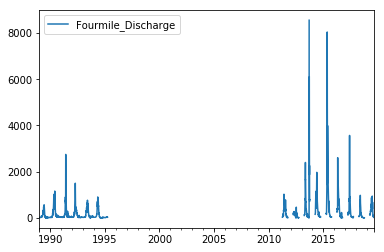

<Figure size 432x288 with 0 Axes>

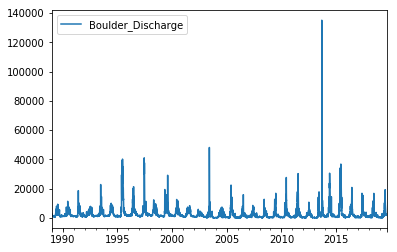

<Figure size 432x288 with 0 Axes>

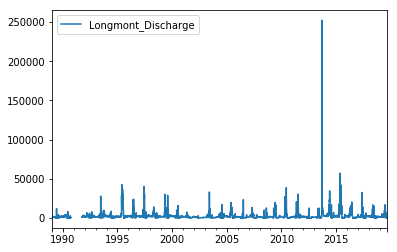

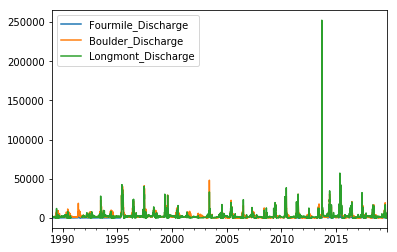

In [11]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*28.3168  # convert to the right unit(m3/s to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### Hydrometeorology

### 2. Precipitation

In [12]:
# Lower Gordon Gulch South-Facing Meteorological Station
# GGL_SF_Met
data1 = pd.read_csv(path + 'raw_GGL_SF_MET.csv', header = 0)
colname = data1.columns[1:]
data1.drop(columns =data1.columns[-1],inplace =True)
data1.columns = colname
prep1 = data1[[' RAIN GAGE(MM)']] # actually rain gage
display(data1.head(2))

RAIN GAGE(MM)   BAROMETRIC PRESS(MBAR)  \
 06/20/2012             0.0                      NaN   
06/21/2012              0.0                      NaN   

              SOIL VOL WATER CONTENT(%)-22CM   SOIL TEMP(C)-22CM  \
 06/20/2012                              0.0               18.93   
06/21/2012                               0.0               17.63   

             WINDSPEED(m/s)-2.5M(AVG)   WINDSPEED(m/s)-2.5M(MAX)  \
 06/20/2012                      0.76                       1.90   
06/21/2012                       0.91                       2.14   

              WINDSPEED(m/s)-2.5M(MIN)   NET RAD(W/m^2)-2.5M  \
 06/20/2012                        0.0                   0.0   
06/21/2012                         NaN                   NaN   

              NET RAD CORR(W/m^2)-2.5M   IN SW RAD(W/m^2)-2.5M(AVG)  \
 06/20/2012                        0.0                          0.0   
06/21/2012                         NaN                          NaN   

              IN SW RAD(MJ/m^2)-2.5M(TOTAL)   AIRTEMP(C)-2.5M(AVG)   RH (%)  \
 06/20/2012                             0.0                  12.63      NaN   
06/21/2012                              NaN                  15.79      NaN   

              RH (MAX)   RH (MIN)  
 06/20/2012        NaN        NaN  
06/21/2012         NaN        NaN

In [13]:
prep1.columns =['GGLSF_Precipitation']
prep1.index = pd.to_datetime(prep1.index)
prep1.tail(2)

GGLSF_Precipitation
2019-07-21                 8.12
2019-07-22                 0.00

In [14]:
# Lower Gordon Gulch North-Facing Meteorological Station (GGL_NF_MET)
data2 = pd.read_csv(path + 'raw_GGL_NF_MET.csv', header = 0)
colname = data2.columns[1:]
data2.drop(columns =data2.columns[-1],inplace =True)
data2.columns = colname
display(data2.head(2))

RAIN GAGE(MM)   BAROMETRIC PRESS(MBAR)  \
 06/08/2012             0.0                      0.0   
06/09/2012              0.0                      NaN   

              SOIL VOL WATER CONTENT(%)-22CM   SOIL TEMP(C)-22CM  \
 06/08/2012                              0.0               12.02   
06/09/2012                               0.0               12.37   

             WINDSPEED(m/s)-2.5M(AVG)   WINDSPEED(m/s)-2.5M(MAX)  \
 06/08/2012                      0.15                        0.0   
06/09/2012                       0.31                        NaN   

              WINDSPEED(m/s)-2.5M(MIN)   NET RAD(W/m^2)-2.5M  \
 06/08/2012                        0.0                 90.79   
06/09/2012                         NaN                 80.63   

              NET RAD CORR(W/m^2)-2.5M   IN SW RAD(W/m^2)-2.5M(AVG)  \
 06/08/2012                      95.31                       205.06   
06/09/2012                       85.31                       208.95   

              IN SW RAD(MJ/m^2)-2.5M(TOTAL)   AIRTEMP(C)-2.5M(AVG)   RH (%)  \
 06/08/2012                             0.0                  18.28      NaN   
06/09/2012                              0.0                  20.67      NaN   

              RH (MAX)   RH (MIN)  
 06/08/2012        NaN        NaN  
06/09/2012         NaN        NaN

In [15]:
prep2 = data2[[' RAIN GAGE(MM)']]
prep2.columns =['GGLNF_Precipitation']
prep2.index = pd.to_datetime(prep2.index)
prep2.tail(2)

GGLNF_Precipitation
2019-06-30                  0.2
2019-07-01                  0.0

In [16]:
# Betasso Meteorology data
dataBetasso = pd.read_csv(path + 'raw_BTMet.csv',header = 0,parse_dates = True,infer_datetime_format = True)
colname = dataBetasso.columns[1:]
dataBetasso.drop(columns = dataBetasso.columns[-1],inplace =True)
dataBetasso.columns = colname
dataBetasso.head(2)

AIRTEMP(C)-2M(AVG)  RH-2M(AVG)  WINDSPEED(m/s)-2M(AVG)  \
2009-02-04               8.739      12.086                   1.739   
2009-02-05              10.493      13.104                   1.138   

            WIND DIR-2M(DEGREES)  WIND DIR-2M STD DEV(DEGREES)  \
2009-02-04               241.195                        17.239   
2009-02-05               196.555                        30.569   

            AIRTEMP(C)-10M(AVG)  RH-10M(AVG)  WINDSPEED(m/s)-10M(AVG)  \
2009-02-04                9.782       11.043                    2.891   
2009-02-05               10.930       12.284                    1.951   

            WINDDIR-10M(DEGREES)  WINDDIR-10M STD DEV(DEGREES)  \
2009-02-04               242.000                        14.673   
2009-02-05               191.555                        27.291   

            IN SW RAD(W/m^2)-5M(AVG)  NET RAD CORR (W/m^2)-5M  \
2009-02-04                    12.586                  -78.717   
2009-02-05                   161.368                   28.777   

            SOIL TEMP(C)-15CM  SOIL VOL WATER CONTENT(%)-15CM  \
2009-02-04              5.217                             0.0   
2009-02-05              3.944                             0.0   

            BAROMETRIC PRESS(MBAR)  TOTAL RAIN GAGE(MM)  
2009-02-04                     NaN                  NaN  
2009-02-05                     NaN                  NaN

In [17]:
s = ['BTMet_AirTemperature_2m','BTMet_RelativeHumidity_2m','BTMet_WindSpeed_2m',
                'BTMet_WindDirection_2m','WIND DIR-2M_STD_DEV(DEGREES)',
                'BTMet_AirTemperature_10m','BTMet_RelativeHumidity_10m','BTMet_WindSpeed_10m',
                'BTMet_WindDirection_10m','WINDDIR-10M_STD_DEV(DEGREES)',
                'IN_SW_RAD(W/m^2)-5M(AVG)','BTMet_SolarRadiation_5m',
                'BTMet_SoilTemperature_15cm','BTMet_SoilMoisture_15cm',
                'BAROMETRIC_PRESS(MBAR)','BTMet_Precipitation']
x =  [i.split('_',1)[1:] for i in s]   
dataBetasso.columns = ['Betasso_' +i[0] for i in x]

In [18]:
prep3 = copy.deepcopy(dataBetasso[['Betasso_Precipitation']])
prep3 = threC(prep3,'Precipitation')

In [19]:
prep = aggre_and_comb_daily([prep1,prep2,prep3], axis=1, func = "sum") 
prep = threC(prep,'Precipitation')

The final table is:


GGLSF_Precipitation GGLNF_Precipitation Betasso_Precipitation
2009-02-04                 NaN                 NaN                   NaN
2009-02-05                 NaN                 NaN                   NaN

GGLSF_Precipitation GGLNF_Precipitation Betasso_Precipitation
2019-07-21                8.12                 NaN                   NaN
2019-07-22                   0                 NaN                   NaN

GGLSF_Precipitation
GGLNF_Precipitation
Betasso_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

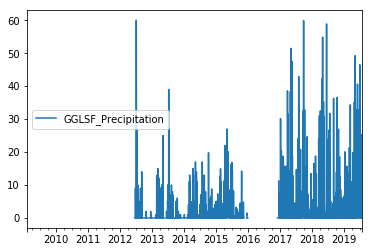

<Figure size 432x288 with 0 Axes>

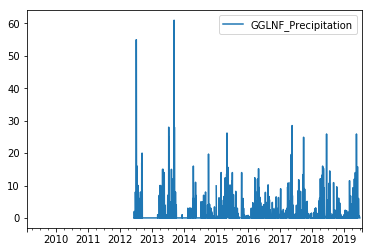

<Figure size 432x288 with 0 Axes>

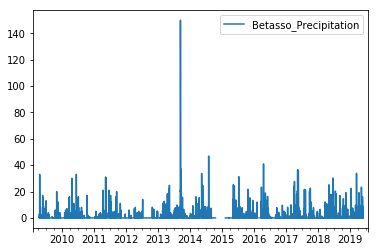

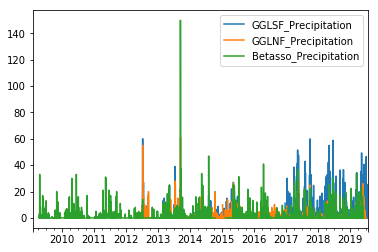

In [20]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature

In [21]:
# Green Lakes Valley 
dataGLV = pd.read_csv('http://culter.colorado.edu/exec/.extracttoolA?d-1cr23x.ml',
                    header = 1,parse_dates = True,skiprows=302,sep = ',',
                   infer_datetime_format = True)
dataGLV = copy.deepcopy(dataGLV.iloc[:-1,[2,8,13,18,28,30,36,41]])
dataGLV.head(2)

2000/07/05  Unnamed: 8  10.03  40.33  Unnamed: 28  1.862  8.58  0.236
0  2000/07/06         NaN  12.34  32.64          NaN  1.441  9.30  0.222
1  2000/07/07         NaN  11.88  39.49          NaN  0.942  9.55  0.211

In [22]:
dataGLV.columns =['DateTime','GreenLakes_SolarRadiation','GreenLakes_AirTemperature',
                  'GreenLakes_RelativeHumidity','GreenLakes_WindSpeed',
                  'GreenLakes_WindDirection','GreenLakes_SoilTemperature',
                  'GreenLakes_SoilMoisture']
dataGLV.set_index('DateTime',inplace = True)
dataGLV.loc['2000/07/05'] = [np.nan, '10.03', '40.33', np.nan, '1.862', '8.58','0.236']
dataGLV = copy.deepcopy(dataGLV.sort_index())
display(dataGLV.head(2))

GreenLakes_SolarRadiation GreenLakes_AirTemperature  \
DateTime                                                          
2000/07/05                        NaN                     10.03   
2000/07/06                        NaN                     12.34   

           GreenLakes_RelativeHumidity  GreenLakes_WindSpeed  \
DateTime                                                       
2000/07/05                       40.33                   NaN   
2000/07/06                       32.64                   NaN   

           GreenLakes_WindDirection GreenLakes_SoilTemperature  \
DateTime                                                         
2000/07/05                    1.862                       8.58   
2000/07/06                    1.441                        9.3   

           GreenLakes_SoilMoisture  
DateTime                            
2000/07/05                   0.236  
2000/07/06                   0.222

In [23]:
prep0 = pd.DataFrame(pd.to_numeric(dataGLV['GreenLakes_AirTemperature']))
prep0.index = pd.to_datetime(prep0.index)
prep0.head(2)

GreenLakes_AirTemperature
DateTime                             
2000-07-05                      10.03
2000-07-06                      12.34

In [24]:
# Gordon Gulch
prep1 = data1[[' AIRTEMP(C)-2.5M(AVG)']] # actually rain gage
prep1.columns =['GGLSF_AirTemperature']
prep1.index = pd.to_datetime(prep1.index)
prep1.tail(2)

GGLSF_AirTemperature
2019-07-21                 15.64
2019-07-22                 12.76

In [25]:
# Gordon Gulch 
prep2 = data2[[' AIRTEMP(C)-2.5M(AVG)']]
prep2.columns =['GGLNF_AirTemperature']
prep2.index = pd.to_datetime(prep2.index)
prep2.tail(2)

GGLNF_AirTemperature
2019-06-30                 15.52
2019-07-01                 13.84

In [26]:
# Betasso
prep3 = copy.deepcopy(dataBetasso[['Betasso_AirTemperature_2m','Betasso_AirTemperature_10m']])

In [27]:
prep = aggre_and_comb_daily([prep0,prep1,prep2,prep3], axis=1, func = "mean") 
prep = threC(prep,'AirTemperature')

The final table is:


GreenLakes_AirTemperature GGLSF_AirTemperature  \
2000-07-05                     10.03                  NaN   
2000-07-06                     12.34                  NaN   

           GGLNF_AirTemperature Betasso_AirTemperature_2m  \
2000-07-05                  NaN                       NaN   
2000-07-06                  NaN                       NaN   

           Betasso_AirTemperature_10m  
2000-07-05                        NaN  
2000-07-06                        NaN

GreenLakes_AirTemperature GGLSF_AirTemperature  \
2019-07-21                       NaN                15.64   
2019-07-22                       NaN                12.76   

           GGLNF_AirTemperature Betasso_AirTemperature_2m  \
2019-07-21                  NaN                       NaN   
2019-07-22                  NaN                       NaN   

           Betasso_AirTemperature_10m  
2019-07-21                        NaN  
2019-07-22                        NaN

GreenLakes_AirTemperature
GGLSF_AirTemperature
GGLNF_AirTemperature
Betasso_AirTemperature_2m
Betasso_AirTemperature_10m


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

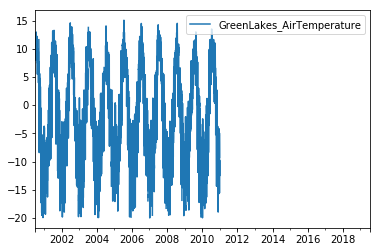

<Figure size 432x288 with 0 Axes>

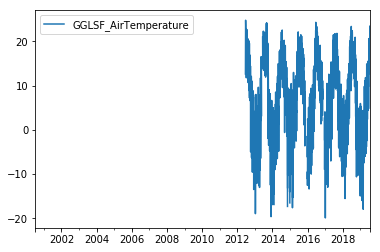

<Figure size 432x288 with 0 Axes>

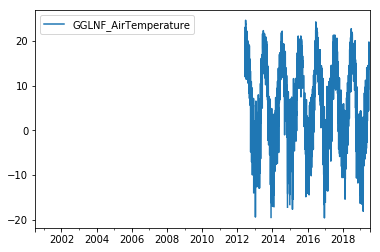

<Figure size 432x288 with 0 Axes>

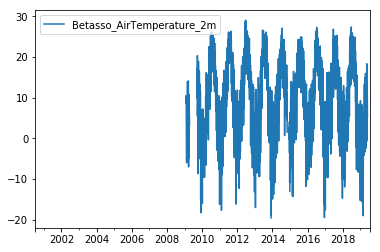

<Figure size 432x288 with 0 Axes>

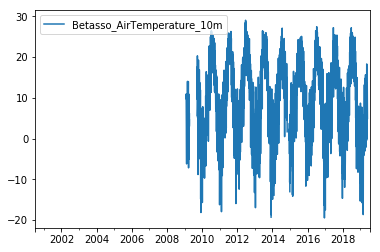

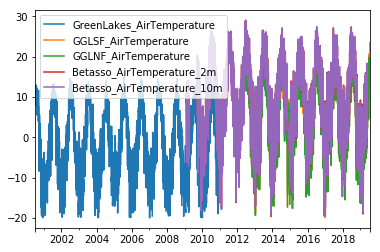

In [28]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Air Temperature unit should be Degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'AirTemperature')   
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. SolarRadiation

In [29]:
# GreenLakes
prep0 = pd.DataFrame(pd.to_numeric(dataGLV['GreenLakes_SolarRadiation']))
prep0.head(2)

GreenLakes_SolarRadiation
DateTime                             
2000/07/05                        NaN
2000/07/06                        NaN

In [30]:
# GordonGulch
prep1 = data1[[' IN SW RAD(W/m^2)-2.5M(AVG)']] # actually rain gage
prep1.columns =['GGLSF_SolarRadiation']
prep1.index = pd.to_datetime(prep1.index)
prep1.head(2)

GGLSF_SolarRadiation
2012-06-20                   0.0
2012-06-21                   NaN

In [31]:
prep2 = data2[[' IN SW RAD(W/m^2)-2.5M(AVG)']]
prep2.columns =['GGLNF_SolarRadiation']
prep2.index = pd.to_datetime(prep2.index)
prep2.head(2)

GGLNF_SolarRadiation
2012-06-08                205.06
2012-06-09                208.95

In [32]:
# Betasso
prep3 = copy.deepcopy(dataBetasso[['Betasso_SolarRadiation_5m']])

In [33]:
df_lst=[prep0,prep1,prep2,prep3]
for df in df_lst:
    df.index=pd.to_datetime(df.index)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep = threC(prep,'SolarRadiation')

The final table is:


GreenLakes_SolarRadiation GGLSF_SolarRadiation  \
2000-07-05                       NaN                  NaN   
2000-07-06                       NaN                  NaN   

           GGLNF_SolarRadiation Betasso_SolarRadiation_5m  
2000-07-05                  NaN                       NaN  
2000-07-06                  NaN                       NaN

GreenLakes_SolarRadiation GGLSF_SolarRadiation  \
2019-07-21                       NaN               242.06   
2019-07-22                       NaN                 0.05   

           GGLNF_SolarRadiation Betasso_SolarRadiation_5m  
2019-07-21                  NaN                       NaN  
2019-07-22                  NaN                       NaN

GreenLakes_SolarRadiation
GGLSF_SolarRadiation
GGLNF_SolarRadiation
Betasso_SolarRadiation_5m


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

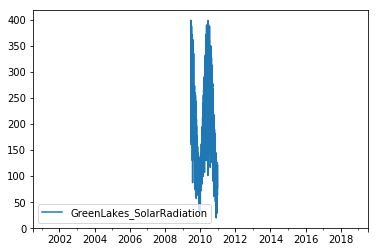

<Figure size 432x288 with 0 Axes>

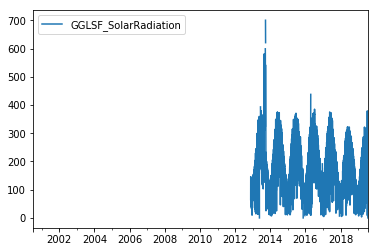

<Figure size 432x288 with 0 Axes>

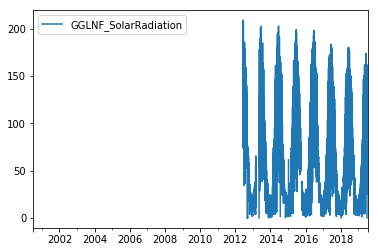

<Figure size 432x288 with 0 Axes>

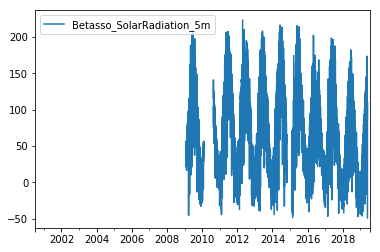

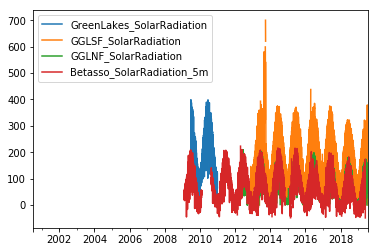

In [34]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Air Temperature unit should be W/m2

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'SolarRadiation')   
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()

### 5. Relative Humidity

In [35]:
# GreenLakesValley
prep0 = pd.DataFrame(pd.to_numeric(dataGLV['GreenLakes_RelativeHumidity']))
prep0.head(2)

GreenLakes_RelativeHumidity
DateTime                               
2000/07/05                        40.33
2000/07/06                        32.64

In [36]:
# GordonGulch
prep1 = data1[[' RH (%)']] # actually rain gage
prep1.columns =['GGLSF_RelativeHumidity']
prep1.index = pd.to_datetime(prep1.index)
prep1.head(2)

GGLSF_RelativeHumidity
2012-06-20                     NaN
2012-06-21                     NaN

In [37]:
# GG
prep2 = data2[[' RH (%)']]
prep2.columns =['GGLNF_RelativeHumidity']
prep2.index = pd.to_datetime(prep2.index)
prep2.head(2)

GGLNF_RelativeHumidity
2012-06-08                     NaN
2012-06-09                     NaN

In [38]:
# Betasso
prep3 = copy.deepcopy(dataBetasso[['Betasso_RelativeHumidity_2m','Betasso_RelativeHumidity_10m']])
prep3.head(2)

Betasso_RelativeHumidity_2m  Betasso_RelativeHumidity_10m
2009-02-04                       12.086                        11.043
2009-02-05                       13.104                        12.284

In [39]:
df_lst=[prep0,prep1,prep2,prep3]
for df in df_lst:
    df.index=pd.to_datetime(df.index)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep = threC(prep,'RelativeHumidity')

The final table is:


GreenLakes_RelativeHumidity GGLSF_RelativeHumidity  \
2000-07-05                       40.33                    NaN   
2000-07-06                       32.64                    NaN   

           GGLNF_RelativeHumidity Betasso_RelativeHumidity_2m  \
2000-07-05                    NaN                         NaN   
2000-07-06                    NaN                         NaN   

           Betasso_RelativeHumidity_10m  
2000-07-05                          NaN  
2000-07-06                          NaN

GreenLakes_RelativeHumidity GGLSF_RelativeHumidity  \
2019-07-21                         NaN                  76.07   
2019-07-22                         NaN                   97.4   

           GGLNF_RelativeHumidity Betasso_RelativeHumidity_2m  \
2019-07-21                    NaN                         NaN   
2019-07-22                    NaN                         NaN   

           Betasso_RelativeHumidity_10m  
2019-07-21                          NaN  
2019-07-22                          NaN

GreenLakes_RelativeHumidity
GGLSF_RelativeHumidity
GGLNF_RelativeHumidity
Betasso_RelativeHumidity_2m
Betasso_RelativeHumidity_10m


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

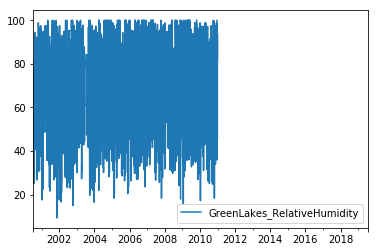

<Figure size 432x288 with 0 Axes>

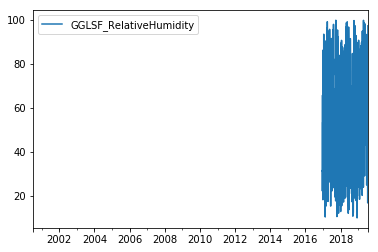

<Figure size 432x288 with 0 Axes>

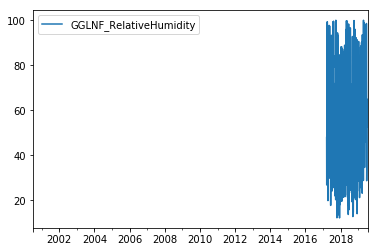

<Figure size 432x288 with 0 Axes>

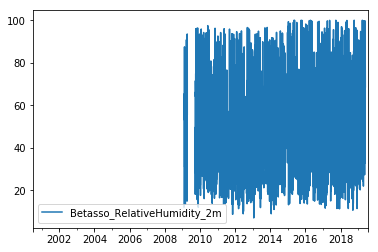

<Figure size 432x288 with 0 Axes>

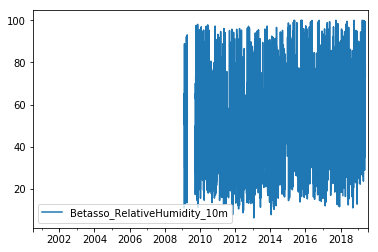

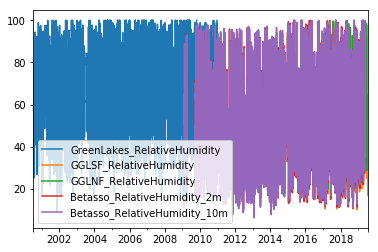

In [40]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! RelativeHumidity unit should be %

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'RelativeHumidity')  
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()

### 6. Wind Direction

GreenLakes_WindDirection
2000-07-05                     1.862
2000-07-06                     1.441
2000-07-07                     0.942
2000-07-08                     1.740
2000-07-09                     2.344

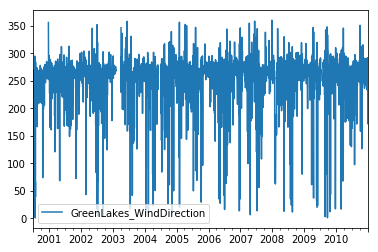

In [41]:
prep = pd.DataFrame(pd.to_numeric(dataGLV['GreenLakes_WindDirection']))
prep = copy.deepcopy(threC(prep,'WindDirection'))
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  

ready_columns = pd.unique(prep.columns)
NAN = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(NAN, index=indexUnique, columns=ready_columns) # create an empty data frame

for i in np.arange(len(ready_columns)):
    tab = prep[ready_columns[i]]
    for j in np.arange(len(tab)):
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j]

                                                                        
WindDirection = copy.deepcopy(df)
WindDirection.plot()
WindDirection.head()

### 7. Wind Speed

In [42]:
prep0 = pd.DataFrame(pd.to_numeric(dataGLV['GreenLakes_WindSpeed']))

In [43]:
prep1 = data1[['WINDSPEED(m/s)-2.5M(AVG)']] # actually rain gage
prep1.columns =['GGLSF_WindSpeed']

In [44]:
prep2 = data2[['WINDSPEED(m/s)-2.5M(AVG)']]
prep2.columns =['GGLNF_WindSpeed']

In [45]:
prep3 = copy.deepcopy(dataBetasso[['Betasso_WindSpeed_2m','Betasso_WindSpeed_10m']])

In [46]:
df_lst=[prep0,prep1,prep2,prep3]
for df in df_lst:
    df.index=pd.to_datetime(df.index)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep = threC(prep,'WindSpeed')

The final table is:


GreenLakes_WindSpeed GGLSF_WindSpeed GGLNF_WindSpeed  \
2000-07-05                  NaN             NaN             NaN   
2000-07-06                  NaN             NaN             NaN   

           Betasso_WindSpeed_2m Betasso_WindSpeed_10m  
2000-07-05                  NaN                   NaN  
2000-07-06                  NaN                   NaN

GreenLakes_WindSpeed GGLSF_WindSpeed GGLNF_WindSpeed  \
2019-07-21                  NaN            0.69             NaN   
2019-07-22                  NaN            0.28             NaN   

           Betasso_WindSpeed_2m Betasso_WindSpeed_10m  
2019-07-21                  NaN                   NaN  
2019-07-22                  NaN                   NaN

GreenLakes_WindSpeed
GGLSF_WindSpeed
GGLNF_WindSpeed
Betasso_WindSpeed_2m
Betasso_WindSpeed_10m


GreenLakes_WindSpeed  GGLSF_WindSpeed  GGLNF_WindSpeed  \
2000-07-05                   NaN              NaN              NaN   
2000-07-06                   NaN              NaN              NaN   
2000-07-07                   NaN              NaN              NaN   
2000-07-08                   NaN              NaN              NaN   
2000-07-09                   NaN              NaN              NaN   

            Betasso_WindSpeed_2m  Betasso_WindSpeed_10m  
2000-07-05                   NaN                    NaN  
2000-07-06                   NaN                    NaN  
2000-07-07                   NaN                    NaN  
2000-07-08                   NaN                    NaN  
2000-07-09                   NaN                    NaN

<Figure size 720x288 with 0 Axes>

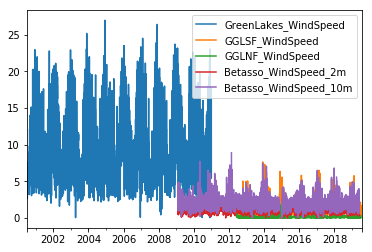

In [47]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j] # 
                       
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head()

### 8. SWE

### 9. SnowDepth

In [48]:
# GordonGulch
# Level 1 Judd Snow Depth Sensors near Lower Gordon Gulch Pole 3
data6 = pd.read_csv(path + 'raw_GGLNF_P3_snow.csv',header = 0)
data6.head(2)

Date Time  GGSD_1(cm)   GGSD_1_L1 Comment  \
03-10-2010 11:50         NaN         NaN                 NaN   
03-10-2010 12:00         NaN         NaN                -1.0   

                   GGSD_1_AIRTEMP(C)  GGSD_2(cm)   GGSD_2_L1 Comment  \
03-10-2010 11:50                 0.0         NaN                -2.0   
03-10-2010 12:00                 0.0         NaN                -2.0   

                   GGSD_2_AIRTEMP(C)  GGSD_3(cm)   GGSD_3_L1 Comment  \
03-10-2010 11:50                 NaN         NaN                -2.0   
03-10-2010 12:00                 NaN         NaN                -2.0   

                   GGSD_3_AIRTEMP(C)  GGSD_4(cm)   GGSD_4_L1 Comment  \
03-10-2010 11:50                 NaN         NaN                -2.0   
03-10-2010 12:00                 NaN         NaN                -2.0   

                   GGSD_4_AIRTEMP(C)   
03-10-2010 11:50                  NaN  
03-10-2010 12:00                  NaN

In [49]:
prep1 = copy.deepcopy(data6.iloc[:,0:11:3])*10
prep1.columns = ['GGLNFP3_SnowDepth_1','GGLNFP3_SnowDepth_2','GGLNFP3_SnowDepth_3','GGLNFP3_SnowDepth_4']
prep1.index = pd.to_datetime(prep1.index)
prep1 = prep1.groupby(prep1.index.date).mean()
prep1.head(2)

GGLNFP3_SnowDepth_1  GGLNFP3_SnowDepth_2  GGLNFP3_SnowDepth_3  \
2010-03-10           221.250000           245.479452           303.833333   
2010-03-11           220.694444           307.708333           308.125000   

            GGLNFP3_SnowDepth_4  
2010-03-10           346.093750  
2010-03-11           353.680556

In [50]:
# Level 1 Judd Snow Depth Sensors near Lower Gordon Gulch Pole 4
data7 = pd.read_csv(path + 'raw_GGLNF_P4_snow.csv',header = 0)
data7.head(2)

Date Time  GGSD_5(cm)   GGSD_5_L1 Comment  \
03-12-2010 13:00         NaN         NaN                 NaN   
03-12-2010 13:10         NaN         NaN                 NaN   

                   GGSD_5_AIRTEMP(C) GGSD_6(cm)   GGSD_6_L1 Comment  \
03-12-2010 13:00                 NaN        NaN                 NaN   
03-12-2010 13:10                 NaN        NaN                 NaN   

                   GGSD_6_AIRTEMP(C) GGSD_7(cm)   GGSD_7_L1 Comment  \
03-12-2010 13:00                 NaN        NaN                 NaN   
03-12-2010 13:10                 NaN        NaN                 NaN   

                   GGSD_7_AIRTEMP(C)  GGSD_8(cm)   GGSD_8_L1 Comment  \
03-12-2010 13:00                 NaN         NaN                 NaN   
03-12-2010 13:10                 NaN         NaN                 NaN   

                   GGSD_8_AIRTEMP(C)  
03-12-2010 13:00                 NaN  
03-12-2010 13:10                 NaN

In [51]:
prep2 = copy.deepcopy(data7.iloc[:,0:11:3])*10
prep2.columns = ['GGLNFP4_SnowDepth_5','GGLNFP4_SnowDepth_6','GGLNFP4_SnowDepth_7','GGLNFP4_SnowDepth_8']
prep2.index = pd.to_datetime(prep2.index)
prep2 = prep2.groupby(prep2.index.date).mean()
prep2.head(2)

GGLNFP4_SnowDepth_5  GGLNFP4_SnowDepth_6  GGLNFP4_SnowDepth_7  \
2010-03-12                  NaN                  NaN                  NaN   
2010-03-14           339.772727           263.787879           382.781955   

            GGLNFP4_SnowDepth_8  
2010-03-12                  NaN  
2010-03-14           281.439394

In [52]:
# Level 1 Judd Snow Depth Sensors near Lower Gordon Gulch Pole 10
data8 = pd.read_csv(path + 'raw_GGLSF_P10_snow.csv',header = 0)
data8.head(2)

Date Time   GGSD_9(cm)   GGSD_9_L1 Comment  \
02-09-2010 13:00         0.0          NaN                -2.0   
02-09-2010 13:10         0.0          NaN                -2.0   

                   GGSD_9_Airtemp(C)  GGSD_10(cm)   GGSD_10_L1 Comment  \
02-09-2010 13:00                 0.0          NaN                 -3.0   
02-09-2010 13:10                 0.0          NaN                 -2.0   

                   GGSD_10_Airtemp(C)  GGSD_11(cm)   GGSD_11_L1 Comment  \
02-09-2010 13:00                  0.0          NaN                 -3.0   
02-09-2010 13:10                  0.0          NaN                 -3.0   

                   GGSD_11_Airtemp(C)  ...   GGSD_13_Airtemp(C)   GGSD_14(cm)  \
02-09-2010 13:00                  0.0  ...                  0.0           NaN   
02-09-2010 13:10                  0.0  ...                  0.0           NaN   

                   GGSD_14_L1 Comment   GGSD_14_Airtemp(C)   GGSD_15(cm)  \
02-09-2010 13:00                 -4.0                  0.0           NaN   
02-09-2010 13:10                 -4.0                  0.0           NaN   

                   GGSD_15_L1 Comment   GGSD_15_Airtemp(C)   GGSD_16(cm)  \
02-09-2010 13:00                   -2                  NaN           NaN   
02-09-2010 13:10                   -1                  NaN           NaN   

                   GGSD_16_L1 Comment   GGSD_16_Airtemp(C)  
02-09-2010 13:00                 -3.0                  NaN  
02-09-2010 13:10                 -3.0                  NaN  

[2 rows x 25 columns]

In [53]:
prep3 = copy.deepcopy(data8.iloc[:,0:24:3])*10
prep3.columns = ['GGLSFP10_SnowDepth_9','GGLSFP10_SnowDepth_10',
                 'GGLSFP10_SnowDepth_11','GGLSFP10_SnowDepth_12',
                 'GGLSFP10_SnowDepth_13','GGLSFP10_SnowDepth_14',
                 'GGLSFP10_SnowDepth_15','GGLSFP10_SnowDepth_16']
prep3.index = pd.to_datetime(prep3.index)
prep3 = prep3.groupby(prep3.index.date).mean()
prep3.head(2)

GGLSFP10_SnowDepth_9  GGLSFP10_SnowDepth_10  \
2010-02-09                   0.0                   10.0   
2010-02-10                   0.0                   30.0   

            GGLSFP10_SnowDepth_11  GGLSFP10_SnowDepth_12  \
2010-02-09                    0.0              25.932203   
2010-02-10                    0.0              23.695652   

            GGLSFP10_SnowDepth_13  GGLSFP10_SnowDepth_14  \
2010-02-09                    0.0                    0.0   
2010-02-10                    0.0                    0.0   

            GGLSFP10_SnowDepth_15  GGLSFP10_SnowDepth_16  
2010-02-09                    0.0             158.666667  
2010-02-10                    0.0             136.956522

In [54]:
# Betasso
data_snow = pd.read_csv(path + 'raw_BT_gully_snow.csv',header = 0)
data_snow.head(2)

Date Time  BTSD_1(cm)   BTSD_1 Comments  \
04-13-2010 13:20         0.0         NaN               NaN   
04-13-2010 13:30         0.0         NaN               NaN   

                   BTSD_1_AIRTEMP(C) BTSD_2(cm)   BTSD_2 Comments  \
04-13-2010 13:20                 0.0        NaN               NaN   
04-13-2010 13:30                 0.0        NaN               NaN   

                   BTSD_2_AIRTEMP(C) BTSD_3(cm)   BTSD_3 Comments  \
04-13-2010 13:20                 0.0        NaN               NaN   
04-13-2010 13:30                 0.0        NaN               NaN   

                   BTSD_3_AIRTEMP(C)  BTSD_4(cm)   BTSD_4 Comments  \
04-13-2010 13:20                 0.0         NaN               NaN   
04-13-2010 13:30                 0.0         NaN               NaN   

                   BTSD_4_AIRTEMP(C)  BTSD_5(cm)   BTSD_5 Comments  \
04-13-2010 13:20                 0.0         NaN               NaN   
04-13-2010 13:30                 0.0         NaN               NaN   

                   BTSD_5_AIRTEMP(C)  
04-13-2010 13:20                 NaN  
04-13-2010 13:30                 NaN

In [55]:
# Judd Snow Depth Sensor (BTSD) sensor 1 to 5
prep4 = copy.deepcopy(data_snow[[' Date Time',' BTSD_1_AIRTEMP(C)',' BTSD_2_AIRTEMP(C)',
                         ' BTSD_3_AIRTEMP(C)',' BTSD_4_AIRTEMP(C)']])*10
prep4.columns = ['BTGully_SnowDepth_1','BTGully_SnowDepth_2','BTGully_SnowDepth_3',
                    'BTGully_SnowDepth_4','BTGully_SnowDepth_5']
prep4.index = pd.to_datetime(prep4.index)
prep4 = prep4.groupby(prep4.index.date).mean()

In [56]:
df_lst=[prep4,prep1,prep2,prep3]
for df in df_lst:
    df.index=pd.to_datetime(df.index)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep = threC(prep,'SnowDepth')

The final table is:


BTGully_SnowDepth_1 BTGully_SnowDepth_2 BTGully_SnowDepth_3  \
2010-02-09                 NaN                 NaN                 NaN   
2010-02-10                 NaN                 NaN                 NaN   

           BTGully_SnowDepth_4 BTGully_SnowDepth_5 GGLNFP3_SnowDepth_1  \
2010-02-09                 NaN                 NaN                 NaN   
2010-02-10                 NaN                 NaN                 NaN   

           GGLNFP3_SnowDepth_2 GGLNFP3_SnowDepth_3 GGLNFP3_SnowDepth_4  \
2010-02-09                 NaN                 NaN                 NaN   
2010-02-10                 NaN                 NaN                 NaN   

           GGLNFP4_SnowDepth_5  ... GGLNFP4_SnowDepth_7 GGLNFP4_SnowDepth_8  \
2010-02-09                 NaN  ...                 NaN                 NaN   
2010-02-10                 NaN  ...                 NaN                 NaN   

           GGLSFP10_SnowDepth_9 GGLSFP10_SnowDepth_10 GGLSFP10_SnowDepth_11  \
2010-02-09                    0                    10                     0   
2010-02-10                    0                    30                     0   

           GGLSFP10_SnowDepth_12 GGLSFP10_SnowDepth_13 GGLSFP10_SnowDepth_14  \
2010-02-09               25.9322                     0                     0   
2010-02-10               23.6957                     0                     0   

           GGLSFP10_SnowDepth_15 GGLSFP10_SnowDepth_16  
2010-02-09                     0               158.667  
2010-02-10                     0               136.957  

[2 rows x 21 columns]

BTGully_SnowDepth_1 BTGully_SnowDepth_2 BTGully_SnowDepth_3  \
2018-09-29                   0                   0                   0   
2018-09-30                   0                   0                   0   

           BTGully_SnowDepth_4 BTGully_SnowDepth_5 GGLNFP3_SnowDepth_1  \
2018-09-29                   0                   0                   0   
2018-09-30                   0                   0                   0   

           GGLNFP3_SnowDepth_2 GGLNFP3_SnowDepth_3 GGLNFP3_SnowDepth_4  \
2018-09-29                   0                   0                 NaN   
2018-09-30                   0                   0                 NaN   

           GGLNFP4_SnowDepth_5  ... GGLNFP4_SnowDepth_7 GGLNFP4_SnowDepth_8  \
2018-09-29                   0  ...                 NaN                 NaN   
2018-09-30                   0  ...                 NaN                 NaN   

           GGLSFP10_SnowDepth_9 GGLSFP10_SnowDepth_10 GGLSFP10_SnowDepth_11  \
2018-09-29                  NaN                   NaN                   NaN   
2018-09-30                  NaN                   NaN                   NaN   

           GGLSFP10_SnowDepth_12 GGLSFP10_SnowDepth_13 GGLSFP10_SnowDepth_14  \
2018-09-29                   NaN                   NaN                   NaN   
2018-09-30                   NaN                   NaN                   NaN   

           GGLSFP10_SnowDepth_15 GGLSFP10_SnowDepth_16  
2018-09-29                   NaN                   NaN  
2018-09-30                   NaN                   NaN  

[2 rows x 21 columns]

BTGully_SnowDepth_1
BTGully_SnowDepth_2
BTGully_SnowDepth_3
BTGully_SnowDepth_4
BTGully_SnowDepth_5
GGLNFP3_SnowDepth_1
GGLNFP3_SnowDepth_2
GGLNFP3_SnowDepth_3
GGLNFP3_SnowDepth_4
GGLNFP4_SnowDepth_5
GGLNFP4_SnowDepth_6
GGLNFP4_SnowDepth_7
GGLNFP4_SnowDepth_8
GGLSFP10_SnowDepth_9
GGLSFP10_SnowDepth_10
GGLSFP10_SnowDepth_11
GGLSFP10_SnowDepth_12
GGLSFP10_SnowDepth_13
GGLSFP10_SnowDepth_14
GGLSFP10_SnowDepth_15
GGLSFP10_SnowDepth_16


BTGully_SnowDepth_1  BTGully_SnowDepth_2  BTGully_SnowDepth_3  \
2010-02-09                  NaN                  NaN                  NaN   
2010-02-10                  NaN                  NaN                  NaN   
2010-02-11                  NaN                  NaN                  NaN   
2010-02-12                  NaN                  NaN                  NaN   
2010-02-13                  NaN                  NaN                  NaN   

            BTGully_SnowDepth_4  BTGully_SnowDepth_5  GGLNFP3_SnowDepth_1  \
2010-02-09                  NaN                  NaN                  NaN   
2010-02-10                  NaN                  NaN                  NaN   
2010-02-11                  NaN                  NaN                  NaN   
2010-02-12                  NaN                  NaN                  NaN   
2010-02-13                  NaN                  NaN                  NaN   

            GGLNFP3_SnowDepth_2  GGLNFP3_SnowDepth_3  GGLNFP3_SnowDepth_4  \
2010-02-09                  NaN                  NaN                  NaN   
2010-02-10                  NaN                  NaN                  NaN   
2010-02-11                  NaN                  NaN                  NaN   
2010-02-12                  NaN                  NaN                  NaN   
2010-02-13                  NaN                  NaN                  NaN   

            GGLNFP4_SnowDepth_5  ...  GGLNFP4_SnowDepth_7  \
2010-02-09                  NaN  ...                  NaN   
2010-02-10                  NaN  ...                  NaN   
2010-02-11                  NaN  ...                  NaN   
2010-02-12                  NaN  ...                  NaN   
2010-02-13                  NaN  ...                  NaN   

            GGLNFP4_SnowDepth_8  GGLSFP10_SnowDepth_9  GGLSFP10_SnowDepth_10  \
2010-02-09                  NaN              0.000000              10.000000   
2010-02-10                  NaN              0.000000              30.000000   
2010-02-11                  NaN              2.037037              39.166667   
2010-02-12                  NaN             21.904762              22.190476   
2010-02-13                  NaN             28.255814               0.000000   

            GGLSFP10_SnowDepth_11  GGLSFP10_SnowDepth_12  \
2010-02-09                    0.0              25.932203   
2010-02-10                    0.0              23.695652   
2010-02-11                    0.0              20.092593   
2010-02-12                    0.0              14.285714   
2010-02-13                    0.0              24.767442   

            GGLSFP10_SnowDepth_13  GGLSFP10_SnowDepth_14  \
2010-02-09               0.000000                    0.0   
2010-02-10               0.000000                    0.0   
2010-02-11               0.092593                    0.0   
2010-02-12               0.000000                    0.0   
2010-02-13               1.976744                    0.0   

            GGLSFP10_SnowDepth_15  GGLSFP10_SnowDepth_16  
2010-02-09                    0.0             158.666667  
2010-02-10                    0.0             136.956522  
2010-02-11                    0.0             120.800000  
2010-02-12                    0.0                    NaN  
2010-02-13                    0.0                    NaN  

[5 rows x 21 columns]

<Figure size 720x288 with 0 Axes>

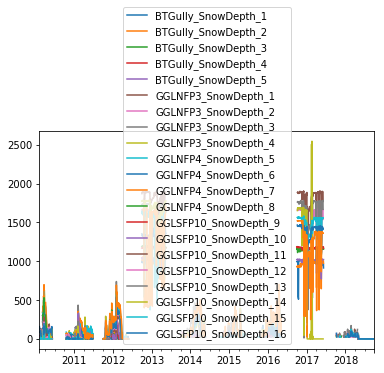

In [57]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j] # 
                       
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()
SnowDepth.head()

### 10. VaporPressure

### 11. SoilMoisture

In [58]:
# GreenLakes
### D1 Niwot Ridge
prepG1 = pd.DataFrame(pd.to_numeric(dataGLV['GreenLakes_SoilMoisture']))*100
prepG1.head(2)

GreenLakes_SoilMoisture
DateTime                           
2000/07/05                     23.6
2000/07/06                     22.2

In [59]:
### Catena 
data_soil = pd.read_csv(path + 'raw_GreenLakes_soil.csv',
                   header = 0,parse_dates = True,skiprows=0,sep = ',',
                   infer_datetime_format = True)
data_soil.head(2)

DATE TIME  Pit1-Vol Water Content-15cm   Pit1-TEMP(C)-15cm  \
2009-09-29      0.120                        6.868               0.197   
2009-09-30      0.119                        5.233               0.195   

             Pit2-Vol Water Content-15cm   Pit2-TEMP(C)-15cm  \
2009-09-29                          5.75               0.289   
2009-09-30                          4.45               0.286   

             Pit3-Vol Water Content-15cm   Pit3-TEMP(C)-15cm  \
2009-09-29                         6.320               0.266   
2009-09-30                         4.757               0.263   

             Pit4-Vol Water Content-11cm   Pit4-TEMP(C)-11cm  \
2009-09-29                         7.686               0.385   
2009-09-30                         3.933               0.375   

             Pit5-Vol Water Content-12cm   Pit5-TEMP(C)-12cm  
2009-09-29                         5.022                 NaN  
2009-09-30                         3.583                 NaN

In [60]:
data_soil.drop(data_soil.columns[-1],axis = 1,inplace = True)
data_soil.columns = ['GLVCatena_SoilMoisture_15cmPit1','GLVCatena_SoilTemperature_15cmPit1',
                'GLVCatena_SoilMoisture_15cmPit2','GLVCatena_SoilTemperature_15cmPit2',
                'GLVCatena_SoilMoisture_15cmPit3','GLVCatena_SoilTemperature_15cmPit3',
                'GLVCatena_SoilMoisture_11cmPit4','GLVCatena_SoilTemperature_11cmPit4',
                'GLVCatena_SoilMoisture_12cmPit5','GLVCatena_SoilTemperature_12cmPit5']
data_soil.head(2)

GLVCatena_SoilMoisture_15cmPit1  \
2009-09-29                            0.120   
2009-09-30                            0.119   

            GLVCatena_SoilTemperature_15cmPit1  \
2009-09-29                               6.868   
2009-09-30                               5.233   

            GLVCatena_SoilMoisture_15cmPit2  \
2009-09-29                            0.197   
2009-09-30                            0.195   

            GLVCatena_SoilTemperature_15cmPit2  \
2009-09-29                                5.75   
2009-09-30                                4.45   

            GLVCatena_SoilMoisture_15cmPit3  \
2009-09-29                            0.289   
2009-09-30                            0.286   

            GLVCatena_SoilTemperature_15cmPit3  \
2009-09-29                               6.320   
2009-09-30                               4.757   

            GLVCatena_SoilMoisture_11cmPit4  \
2009-09-29                            0.266   
2009-09-30                            0.263   

            GLVCatena_SoilTemperature_11cmPit4  \
2009-09-29                               7.686   
2009-09-30                               3.933   

            GLVCatena_SoilMoisture_12cmPit5  \
2009-09-29                            0.385   
2009-09-30                            0.375   

            GLVCatena_SoilTemperature_12cmPit5  
2009-09-29                               5.022  
2009-09-30                               3.583

In [61]:
prepG2 = copy.deepcopy(data_soil.iloc[:,[0,2,4,6,8]])*100
prepG2.head(2)

GLVCatena_SoilMoisture_15cmPit1  GLVCatena_SoilMoisture_15cmPit2  \
2009-09-29                             12.0                             19.7   
2009-09-30                             11.9                             19.5   

            GLVCatena_SoilMoisture_15cmPit3  GLVCatena_SoilMoisture_11cmPit4  \
2009-09-29                             28.9                             26.6   
2009-09-30                             28.6                             26.3   

            GLVCatena_SoilMoisture_12cmPit5  
2009-09-29                             38.5  
2009-09-30                             37.5

In [62]:
# GordonGulch

In [63]:
# LSFMET
prep1 = data1[[' SOIL VOL WATER CONTENT(%)-22CM']] # actually rain gage
prep1.columns =['GGLSF_SoilMoisture_22cm']
prep1.index = pd.to_datetime(prep1.index)
prep1 = prep1.groupby(prep1.index.date).mean()
prep1.head(2)

GGLSF_SoilMoisture_22cm
2012-06-20                      0.0
2012-06-21                      0.0

In [64]:
# LNFMET
prep2 = data2[[' SOIL VOL WATER CONTENT(%)-22CM']]
prep2.columns =['GGLNF_SoilMoisture_22cm']
prep2.index = pd.to_datetime(prep2.index)
prep2.tail(2)

GGLNF_SoilMoisture_22cm
2019-06-30                     0.17
2019-07-01                     0.17

In [65]:
# Gordon Gulch: Lower - Electrical Conductivity, Soil Moisture, Soil Temperature - South-Facing Middle Pit 
# GGL_SF_MP
data3 = pd.read_csv(path + 'raw_GG_LSFMP_Soil.csv',header = 0)
colname = data3.columns[1:]
data3.drop(columns = data3.columns[-1],inplace = True)
data3.columns = colname
data3.head(2)

5TE(40CM)-VOL WATER CONTENT   5TE(40CM)-TEMP(C)  \
01/21/2012                         0.12               1.224   
01/22/2012                         0.12               1.393   

             5TE(40CM)-BULK ELEC COND(mS)   5TE(60CM)-VOL WATER CONTENT  \
01/21/2012                            0.0                          0.13   
01/22/2012                            0.0                          0.13   

             5TE(60CM)-TEMP(C)   5TE(60CM)-BULK ELEC COND(mS)   \
01/21/2012                 1.8                           0.029   
01/22/2012                 1.8                           0.029   

             5TE(100CM)-VOL WATER CONTENT   5TE(100CM)-TEMP(C)  \
01/21/2012                           0.09                  2.7   
01/22/2012                           0.09                  2.7   

             5TE(100CM)-BULK ELEC COND(mS)   MPS(60CM)WATER POTENTIAL(kPa)  \
01/21/2012                             0.0                          -5.694   
01/22/2012                             0.0                          -5.709   

             MPS(60CM)TEMP(C)   MPS(100CM)WATER POTENTIAL(kPa)  \
01/21/2012                1.8                           -5.833   
01/22/2012                1.8                           -5.834   

             MPS(100CM)TEMP(C)  
01/21/2012                 2.5  
01/22/2012                 2.5

In [66]:
prep3 = copy.deepcopy(data3.iloc[:,[0,3,6]])*100
prep3.index = pd.to_datetime(prep3.index)
prep3.columns = ['GGLSFMP_SoilMoisture_40cm','GGLSFMP_SoilMoisture_60cm','GGLSFMP_SoilMoisture_100cm']
prep3.tail(2)

GGLSFMP_SoilMoisture_40cm  GGLSFMP_SoilMoisture_60cm  \
2017-10-11                        NaN                        NaN   
2017-10-12                        NaN                        NaN   

            GGLSFMP_SoilMoisture_100cm  
2017-10-11                         NaN  
2017-10-12                         NaN

In [67]:
# Gordon Gulch: Lower - Electrical Conductivity, Soil Moisture, Soil Temperature - North-Facing Middle Pit 
# GGL_NF_MP
data4 = pd.read_csv(path + 'raw_GG_LNFMP_Soil.csv',header = 0)
colname = data4.columns[1:]
data4.drop(columns = data4.columns[-1],inplace = True)
data4.columns = colname
data4.head(2)

5TE(20CM)-VOL WATER CONTENT   5TE(20CM)-TEMP(C)  \
11/21/2011                        0.054               0.348   
11/22/2011                        0.055               0.070   

             5TE(20CM)-BULK ELEC COND(mS)   5TE(35CM)-VOL WATER CONTENT  \
11/21/2011                            0.0                         0.049   
11/22/2011                            0.0                         0.050   

             5TE(35CM)-TEMP(C)   5TE(35CM)-BULK ELEC COND(mS)   \
11/21/2011               0.675                             0.0   
11/22/2011               0.500                             0.0   

             5TE(75CM)-VOL WATER CONTENT   5TE(75CM)-TEMP(C)  \
11/21/2011                         0.015               1.285   
11/22/2011                         0.016               1.257   

             5TE(75CM)-BULK ELEC COND(mS)   MPS(35CM)-WATER POTENTIAL(kPa)  \
11/21/2011                            0.0                          -46.390   
11/22/2011                            0.0                          -48.452   

             MPS(35CM)-TEMP(C)   MPS(75CM)-WATER POTENTIAL(kPa)  \
11/21/2011               0.528                          -40.100   
11/22/2011               0.471                          -43.866   

             MPS(75CM)-TEMP(C)  
11/21/2011               1.189  
11/22/2011               1.148

In [68]:
prep4 = copy.deepcopy(data4.iloc[:,[0,3,6]])*100
prep4.index = pd.to_datetime(prep4.index)
prep4.columns = ['GGLNFMP_SoilMoisture_20cm','GGLNFMP_SoilMoisture_35cm','GGLNFMP_SoilMoisture_75cm']
prep4.tail(2)

GGLNFMP_SoilMoisture_20cm  GGLNFMP_SoilMoisture_35cm  \
2018-07-26                       14.5                        6.5   
2018-07-27                       13.9                        6.5   

            GGLNFMP_SoilMoisture_75cm  
2018-07-26                        NaN  
2018-07-27                        NaN

In [69]:
# GGLNFSP3
datasp3 = pd.read_csv(path + 'ggl-nf-sp3-sltmpslmst-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
datasp3.head(2)

SR-TEMP(C)-5CM  SR-VOL WATER CONTENT-5CM  SR-TEMP(C)-19CM  \
DATE_TIME                                                                    
9/30/2018 23:50            9.33                     0.034             9.60   
9/30/2018 23:40            9.35                     0.033             9.61   

                 SR-VOL WATER CONTENT-19CM  SM-TEMP(C)-5CM  \
DATE_TIME                                                    
9/30/2018 23:50                       0.04           10.03   
9/30/2018 23:40                       0.04           10.05   

                 SM-VOL WATER CONTENT-5CM  SM-TEMP(C)-25CM  \
DATE_TIME                                                    
9/30/2018 23:50                     0.045            10.58   
9/30/2018 23:40                     0.045            10.58   

                 SM-VOL WATER CONTENT-25CM  
DATE_TIME                                   
9/30/2018 23:50                      0.057  
9/30/2018 23:40                      0.057

In [70]:
prep = copy.deepcopy(datasp3.iloc[:,[1,3,5,7]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP3_SoilMoisture_SR5cm','GGLNFSP3_SoilMoisture_SR19cm',
                 'GGLNFSP3_SoilMoisture_SM5cm','GGLNFSP3_SoilMoisture_SM25cm']
prep5 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep5.head(2)

GGLNFSP3_SoilMoisture_SR5cm  GGLNFSP3_SoilMoisture_SR19cm  \
2010-06-01                     8.054861                      7.855556   
2010-06-02                     7.693750                      7.554167   

            GGLNFSP3_SoilMoisture_SM5cm  GGLNFSP3_SoilMoisture_SM25cm  
2010-06-01                    12.945833                     13.675000  
2010-06-02                    12.465278                     13.349306

In [71]:
# GGLNFSP4
datasp4 = pd.read_csv(path + 'ggl-nf-sp4-sltmpslmst-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
datasp4.head(2)

SR-TEMP(C)-5CM  SR-VOL WATER CONTENT-5CM  SR-TEMP(C)-25CM  \
DATE_TIME                                                                    
9/30/2018 23:50        7.183960                     0.039         8.566742   
9/30/2018 23:40        7.211914                     0.039         8.575348   

                 SR-VOL WATER CONTENT-25CM  SM-TEMP(C)-5CM  \
DATE_TIME                                                    
9/30/2018 23:50                      0.052           7.417   
9/30/2018 23:40                      0.053           7.445   

                 SM-VOL WATER CONTENT-5CM  SM-TEMP(C)-20CM  \
DATE_TIME                                                    
9/30/2018 23:50                     0.017             8.62   
9/30/2018 23:40                     0.017             8.61   

                 SM-VOL WATER CONTENT-20CM  
DATE_TIME                                   
9/30/2018 23:50                       0.04  
9/30/2018 23:40                       0.04

In [72]:
prep = copy.deepcopy(datasp4.iloc[:,[1,3,5,7]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP4_SoilMoisture_SR5cm','GGLNFSP4_SoilMoisture_SR25cm',
                 'GGLNFSP4_SoilMoisture_SM5cm','GGLNFSP4_SoilMoisture_SM20cm']
prep6 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep6.head(2)

GGLNFSP4_SoilMoisture_SR5cm  GGLNFSP4_SoilMoisture_SR25cm  \
2009-09-12                          NaN                           NaN   
2009-09-13                          NaN                           NaN   

            GGLNFSP4_SoilMoisture_SM5cm  GGLNFSP4_SoilMoisture_SM20cm  
2009-09-12                     1.637293                      3.726293  
2009-09-13                     1.767812                      3.724063

In [73]:
# GGLNFSP5
datasp5 = pd.read_csv(path + 'ggl-nf-sp5-sltmpslmst-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
datasp5.head(2)

SR-TEMP(C)-5CM  SR-VOL WATER CONTENT-5CM  SR-TEMP(C)-10CM  \
DATE_TIME                                                                    
9/30/2018 23:50        6.186218                     0.065         7.065433   
9/30/2018 23:40        6.222968                     0.065         7.088763   

                 SR-VOL WATER CONTENT-10CM  SR-TEMP(C)-25CM  \
DATE_TIME                                                     
9/30/2018 23:50                      0.062         7.630356   
9/30/2018 23:40                      0.062         7.644040   

                 SR-VOL WATER CONTENT-25CM  SR-TEMP(C)-60CM  \
DATE_TIME                                                     
9/30/2018 23:50                      0.059         7.805176   
9/30/2018 23:40                      0.059         7.801270   

                 SR-VOL WATER CONTENT-60CM  SM-TEMP(C)-7CM  \
DATE_TIME                                                    
9/30/2018 23:50                      0.066        7.092651   
9/30/2018 23:40                      0.066        7.124738   

                 SM-VOL WATER CONTENT-7CM  SM-TEMP(C)-20CM  \
DATE_TIME                                                    
9/30/2018 23:50                     0.042         8.053644   
9/30/2018 23:40                     0.042         8.067343   

                 SM-VOL WATER CONTENT-20CM  SM-TEMP(C)-50CM  \
DATE_TIME                                                     
9/30/2018 23:50                      0.072         7.899017   
9/30/2018 23:40                      0.072         7.899017   

                 SM-VOL WATER CONTENT-50CM  SM-TEMP(C)-120CM  \
DATE_TIME                                                      
9/30/2018 23:50                      0.062          7.960663   
9/30/2018 23:40                      0.062          7.963593   

                 SM-VOL WATER CONTENT-120CM  
DATE_TIME                                    
9/30/2018 23:50                       0.065  
9/30/2018 23:40                       0.065

In [74]:
prep = copy.deepcopy(datasp5.iloc[:,[1,3,5,7,9,11,13,15]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP5_SoilMoisture_SR5cm','GGLNFSP5_SoilMoisture_SR10cm','GGLNFSP5_SoilMoisture_SR25cm','GGLNFSP5_SoilMoisture_SR60cm',
                'GGLNFSP5_SoilMoisture_SM7cm','GGLNFSP5_SoilMoisture_SM20cm','GGLNFSP5_SoilMoisture_SM50cm','GGLNFSP5_SoilMoisture_SM120cm']
prep7 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep7.head(2)

GGLNFSP5_SoilMoisture_SR5cm  GGLNFSP5_SoilMoisture_SR10cm  \
2009-09-07                          NaN                           NaN   
2009-09-08                          NaN                           NaN   

            GGLNFSP5_SoilMoisture_SR25cm  GGLNFSP5_SoilMoisture_SR60cm  \
2009-09-07                           NaN                           NaN   
2009-09-08                           NaN                           NaN   

            GGLNFSP5_SoilMoisture_SM7cm  GGLNFSP5_SoilMoisture_SM20cm  \
2009-09-07                     3.611542                       8.15061   
2009-09-08                     3.589799                       8.11941   

            GGLNFSP5_SoilMoisture_SM50cm  GGLNFSP5_SoilMoisture_SM120cm  
2009-09-07                      6.718932                       6.738237  
2009-09-08                      6.702229                       6.707118

In [75]:
# GGLNFSP6
datasp6 = pd.read_csv(path + 'ggl-sf-sp6-sltmpslmst-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
datasp6.head(2)

Vol Water Content-5cm  TEMP(C)-5cm  Vol Water Content-25cm  \
DATE_TIME                                                                     
9/30/2018 23:50                  0.014        6.975                   0.068   
9/30/2018 23:40                  0.014        7.022                   0.068   

                 TEMP(C)-25cm  
DATE_TIME                      
9/30/2018 23:50         15.87  
9/30/2018 23:40         15.88

In [76]:
prep = copy.deepcopy(datasp6.iloc[:,[0,2]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP6_SoilMoisture_5cm','GGLNFSP6_SoilMoisture_25cm']
prep8 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep8.head(2)

GGLNFSP6_SoilMoisture_5cm  GGLNFSP6_SoilMoisture_25cm
2009-09-02                   1.881000                    7.598750
2009-09-03                   1.884667                    7.523264

In [77]:
# GGLNFSP9
datasp9 = pd.read_csv(path + 'ggl-sf-sp9-sltmpslmst-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
datasp9.head(2)

SR-TEMP(C)-5CM  SR-VOL WATER CONTENT-5CM  SR-TEMP(C)-22CM  \
DATE_TIME                                                                    
9/30/2018 23:50           5.254                     0.003            17.69   
9/30/2018 23:40           5.408                     0.003            17.74   

                 SR-VOL WATER CONTENT-22CM  SM-TEMP(C)-5CM  \
DATE_TIME                                                    
9/30/2018 23:50                      0.047           11.62   
9/30/2018 23:40                      0.047           11.68   

                 SM-VOL WATER CONTENT-5CM  SM-TEMP(C)-20CM  \
DATE_TIME                                                    
9/30/2018 23:50                     0.032            15.04   
9/30/2018 23:40                     0.032            15.08   

                 SM-VOL WATER CONTENT-20CM  
DATE_TIME                                   
9/30/2018 23:50                      0.048  
9/30/2018 23:40                      0.048

In [78]:
prep = copy.deepcopy(datasp9.iloc[:,[1,3,5,7]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP9_SoilMoisture_SR5cm','GGLNFSP9_SoilMoisture_SR22cm',
                 'GGLNFSP9_SoilMoisture_SM5cm','GGLNFSP9_SoilMoisture_SM20cm']
prep9 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep9.head(2)

GGLNFSP9_SoilMoisture_SR5cm  GGLNFSP9_SoilMoisture_SR22cm  \
2010-04-06                          NaN                           NaN   
2010-04-07                          NaN                           NaN   

            GGLNFSP9_SoilMoisture_SM5cm  GGLNFSP9_SoilMoisture_SM20cm  
2010-04-06                    13.274684                     14.558228  
2010-04-07                    13.618056                     14.521528

In [79]:
# GGLNFSP10
datasp10 = pd.read_csv(path + 'ggl-sf-sp10-sltmpslmst-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
datasp10.head(2)

SR-TEMP(C)-5CM  SR-VOL WATER CONTENT-5CM  SR-TEMP(C)-25CM  \
DATE_TIME                                                                    
9/30/2018 23:50        18.88370                     0.043         14.71075   
9/30/2018 23:40        18.90662                     0.043         14.71075   

                 SR-VOL WATER CONTENT-25CM  SM-TEMP(C)-5CM  \
DATE_TIME                                                    
9/30/2018 23:50                      0.041           14.44   
9/30/2018 23:40                      0.041           14.47   

                 SM-VOL WATER CONTENT-5CM  SM-TEMP(C)-25CM  \
DATE_TIME                                                    
9/30/2018 23:50                      0.02            15.60   
9/30/2018 23:40                      0.02            15.62   

                 SM-VOL WATER CONTENT-25CM  
DATE_TIME                                   
9/30/2018 23:50                      0.035  
9/30/2018 23:40                      0.035

In [80]:
prep = copy.deepcopy(datasp10.iloc[:,[1,3,5,7]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP10_SoilMoisture_SR5cm','GGLNFSP10_SoilMoisture_SR25cm',
                 'GGLNFSP10_SoilMoisture_SM5cm','GGLNFSP10_SoilMoisture_SM25cm']
prep10 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep10.head(2)

GGLNFSP10_SoilMoisture_SR5cm  GGLNFSP10_SoilMoisture_SR25cm  \
2010-02-09                           NaN                            NaN   
2010-02-10                           NaN                            NaN   

            GGLNFSP10_SoilMoisture_SM5cm  GGLNFSP10_SoilMoisture_SM25cm  
2010-02-09                           NaN                            NaN  
2010-02-10                           NaN                            NaN

In [81]:
# GGUNFSP4
dataggu = pd.read_csv(path + 'ggu-nf-sp4-sltmpslmst-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
dataggu.head(2)

Vol Water Content-5cm  TEMP(C)-5cm  Vol Water Content-50cm  \
DATE_TIME                                                                     
9/30/2018 23:50                  0.048        7.916                   0.087   
9/30/2018 23:40                  0.048        7.950                   0.087   

                 TEMP(C)-50cm  Vol Water Content-100cm  TEMP(C)-100cm  \
DATE_TIME                                                               
9/30/2018 23:50          8.32                    0.179           8.37   
9/30/2018 23:40          8.31                    0.179           8.37   

                 Vol Water Content-138cm  TEMP(C)-138cm  
DATE_TIME                                                
9/30/2018 23:50                    0.217           8.37  
9/30/2018 23:40                    0.217           8.37

In [82]:
prep = copy.deepcopy(dataggu.iloc[:,[0,2,4,6]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGUNFSP4_SoilMoisture_5cm','GGUNFSP4_SoilMoisture_50cm',
               'GGUNFSP4_SoilMoisture_100cm','GGUNFSP4_SoilMoisture_138cm']
prep11 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep11.head(2)

GGUNFSP4_SoilMoisture_5cm  GGUNFSP4_SoilMoisture_50cm  \
2009-08-04                  17.996000                   17.695592   
2009-08-05                  17.559049                   17.667833   

            GGUNFSP4_SoilMoisture_100cm  GGUNFSP4_SoilMoisture_138cm  
2009-08-04                    28.191487                    28.787539  
2009-08-05                    28.205257                    28.756778

In [83]:
### Betasso
prep12 = copy.deepcopy(dataBetasso[['Betasso_SoilMoisture_15cm']])*100
prep12.head(2)

Betasso_SoilMoisture_15cm
2009-02-04                        0.0
2009-02-05                        0.0

In [84]:
# BTGully2
datagully = pd.read_csv(path + 'bt-gully-slmstwrptn-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
datagully.head(2)

VOL WATER CONTENT-15CM  WATER POTENTIAL-15CM(mV)  \
DATE_TIME                                                           
9/30/2018 23:50                   0.049                     584.3   
9/30/2018 23:40                   0.049                     584.3   

                 WATER POTENTIAL-15CM(kPa)  VOL WATER CONTENT-40CM  \
DATE_TIME                                                            
9/30/2018 23:50                     -604.6                   0.006   
9/30/2018 23:40                     -606.0                   0.006   

                 WATER POTENTIAL-40CM(mV)  WATER POTENTIAL-40CM(kPa)  \
DATE_TIME                                                              
9/30/2018 23:50                     574.7                     -798.3   
9/30/2018 23:40                     574.7                     -800.0   

                 VOL WATER CONTENT-70CM  WATER POTENTIAL-70CM(mV)  \
DATE_TIME                                                           
9/30/2018 23:50                   0.083                     578.1   
9/30/2018 23:40                   0.083                     578.0   

                 WATER POTENTIAL-70CM(kPa)  
DATE_TIME                                   
9/30/2018 23:50                     -723.3  
9/30/2018 23:40                     -726.1

In [85]:
prep = copy.deepcopy(datagully.iloc[:,[0,3,6]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['BTGully2_SoilMoisture_15cm','BTGully2_SoilMoisture_40cm',
               'BTGully2_SoilMoisture_70cm']
prep13 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep13.head(2)

BTGully2_SoilMoisture_15cm  BTGully2_SoilMoisture_40cm  \
2010-04-13                   10.490625                    4.832813   
2010-04-14                   10.610417                    4.450694   

            BTGully2_SoilMoisture_70cm  
2010-04-13                    5.770312  
2010-04-14                    6.130556

In [86]:
# BTBorrow
databorrow = pd.read_csv(path + 'bt-borrow-slmstwrptn-toWY2018.csv',header = 0,index_col = 'DATE_TIME')
databorrow.head(2)

VOL WATER CONTENT-40CM  WATER POTENTIAL-40CM(mV)  \
DATE_TIME                                                           
9/30/2018 23:50                   0.054                     586.0   
9/30/2018 23:40                   0.054                     586.0   

                 WATER POTENTIAL-40CM(kPa)  VOL WATER CONTENT-70CM  \
DATE_TIME                                                            
9/30/2018 23:50                     -576.3                   0.049   
9/30/2018 23:40                     -576.2                   0.049   

                 WATER POTENTIAL-70CM(mV)  WATER POTENTIAL-70CM(kPa)  \
DATE_TIME                                                              
9/30/2018 23:50                     589.4                     -524.2   
9/30/2018 23:40                     591.4                     -495.5   

                 VOL WATER CONTENT-110CM  WATER POTENTIAL-110CM(mV)  \
DATE_TIME                                                             
9/30/2018 23:50                    0.088                      601.5   
9/30/2018 23:40                    0.089                      602.8   

                 WATER POTENTIAL-110CM(kPa)  
DATE_TIME                                    
9/30/2018 23:50                      -376.2  
9/30/2018 23:40                      -362.8

In [87]:
prep = copy.deepcopy(datagully.iloc[:,[0,3,6]])*100
prep.index = pd.to_datetime(prep.index)
prep.columns = ['BTBorrow_SoilMoisture_40cm','BTBorrow_SoilMoisture_70cm','BTBorrow_SoilMoisture_110cm']
prep14 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep14.head(2)

BTBorrow_SoilMoisture_40cm  BTBorrow_SoilMoisture_70cm  \
2010-04-13                   10.490625                    4.832813   
2010-04-14                   10.610417                    4.450694   

            BTBorrow_SoilMoisture_110cm  
2010-04-13                     5.770312  
2010-04-14                     6.130556

In [88]:
df_lst=[prepG1,prepG2,prep1,prep2,prep3,prep4,prep5,prep6,prep7,prep8,prep9,prep10,prep11,prep12,prep13,prep14]
for df in df_lst:
    df.index=pd.to_datetime(df.index)
    df = threC(df,'SoilMoisture')
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

The final table is:


GreenLakes_SoilMoisture GLVCatena_SoilMoisture_15cmPit1  \
2000-07-05                    23.6                             NaN   
2000-07-06                    22.2                             NaN   

           GLVCatena_SoilMoisture_15cmPit2 GLVCatena_SoilMoisture_15cmPit3  \
2000-07-05                             NaN                             NaN   
2000-07-06                             NaN                             NaN   

           GLVCatena_SoilMoisture_11cmPit4 GLVCatena_SoilMoisture_12cmPit5  \
2000-07-05                             NaN                             NaN   
2000-07-06                             NaN                             NaN   

           GGLSF_SoilMoisture_22cm GGLNF_SoilMoisture_22cm  \
2000-07-05                     NaN                     NaN   
2000-07-06                     NaN                     NaN   

           GGLSFMP_SoilMoisture_40cm GGLSFMP_SoilMoisture_60cm  ...  \
2000-07-05                       NaN                       NaN  ...   
2000-07-06                       NaN                       NaN  ...   

           GGUNFSP4_SoilMoisture_50cm GGUNFSP4_SoilMoisture_100cm  \
2000-07-05                        NaN                         NaN   
2000-07-06                        NaN                         NaN   

           GGUNFSP4_SoilMoisture_138cm Betasso_SoilMoisture_15cm  \
2000-07-05                         NaN                       NaN   
2000-07-06                         NaN                       NaN   

           BTGully2_SoilMoisture_15cm BTGully2_SoilMoisture_40cm  \
2000-07-05                        NaN                        NaN   
2000-07-06                        NaN                        NaN   

           BTGully2_SoilMoisture_70cm BTBorrow_SoilMoisture_40cm  \
2000-07-05                        NaN                        NaN   
2000-07-06                        NaN                        NaN   

           BTBorrow_SoilMoisture_70cm BTBorrow_SoilMoisture_110cm  
2000-07-05                        NaN                         NaN  
2000-07-06                        NaN                         NaN  

[2 rows x 51 columns]

GreenLakes_SoilMoisture GLVCatena_SoilMoisture_15cmPit1  \
2019-07-21                     NaN                             NaN   
2019-07-22                     NaN                             NaN   

           GLVCatena_SoilMoisture_15cmPit2 GLVCatena_SoilMoisture_15cmPit3  \
2019-07-21                             NaN                             NaN   
2019-07-22                             NaN                             NaN   

           GLVCatena_SoilMoisture_11cmPit4 GLVCatena_SoilMoisture_12cmPit5  \
2019-07-21                             NaN                             NaN   
2019-07-22                             NaN                             NaN   

           GGLSF_SoilMoisture_22cm GGLNF_SoilMoisture_22cm  \
2019-07-21                    0.14                     NaN   
2019-07-22                    0.14                     NaN   

           GGLSFMP_SoilMoisture_40cm GGLSFMP_SoilMoisture_60cm  ...  \
2019-07-21                       NaN                       NaN  ...   
2019-07-22                       NaN                       NaN  ...   

           GGUNFSP4_SoilMoisture_50cm GGUNFSP4_SoilMoisture_100cm  \
2019-07-21                        NaN                         NaN   
2019-07-22                        NaN                         NaN   

           GGUNFSP4_SoilMoisture_138cm Betasso_SoilMoisture_15cm  \
2019-07-21                         NaN                       NaN   
2019-07-22                         NaN                       NaN   

           BTGully2_SoilMoisture_15cm BTGully2_SoilMoisture_40cm  \
2019-07-21                        NaN                        NaN   
2019-07-22                        NaN                        NaN   

           BTGully2_SoilMoisture_70cm BTBorrow_SoilMoisture_40cm  \
2019-07-21                        NaN                        NaN   
2019-07-22                        NaN                        NaN   

           BTBorrow_SoilMoisture_70cm BTBorrow_SoilMoisture_110cm  
2019-07-21                        NaN                         NaN  
2019-07-22                        NaN                         NaN  

[2 rows x 51 columns]

GreenLakes_SoilMoisture
GLVCatena_SoilMoisture_15cmPit1
GLVCatena_SoilMoisture_15cmPit2
GLVCatena_SoilMoisture_15cmPit3
GLVCatena_SoilMoisture_11cmPit4
GLVCatena_SoilMoisture_12cmPit5
GGLSF_SoilMoisture_22cm
GGLNF_SoilMoisture_22cm
GGLSFMP_SoilMoisture_40cm
GGLSFMP_SoilMoisture_60cm
GGLSFMP_SoilMoisture_100cm
GGLNFMP_SoilMoisture_20cm
GGLNFMP_SoilMoisture_35cm
GGLNFMP_SoilMoisture_75cm
GGLNFSP3_SoilMoisture_SR5cm
GGLNFSP3_SoilMoisture_SR19cm
GGLNFSP3_SoilMoisture_SM5cm
GGLNFSP3_SoilMoisture_SM25cm
GGLNFSP4_SoilMoisture_SR5cm
GGLNFSP4_SoilMoisture_SR25cm
GGLNFSP4_SoilMoisture_SM5cm
GGLNFSP4_SoilMoisture_SM20cm
GGLNFSP5_SoilMoisture_SR5cm
GGLNFSP5_SoilMoisture_SR10cm
GGLNFSP5_SoilMoisture_SR25cm
GGLNFSP5_SoilMoisture_SR60cm
GGLNFSP5_SoilMoisture_SM7cm
GGLNFSP5_SoilMoisture_SM20cm
GGLNFSP5_SoilMoisture_SM50cm
GGLNFSP5_SoilMoisture_SM120cm
GGLNFSP6_SoilMoisture_5cm
GGLNFSP6_SoilMoisture_25cm
GGLNFSP9_SoilMoisture_SR5cm
GGLNFSP9_SoilMoisture_SR22cm
GGLNFSP9_SoilMoisture_SM5cm
GGLNFSP9_SoilM

GreenLakes_SoilMoisture  GLVCatena_SoilMoisture_15cmPit1  \
2000-07-05                     23.6                              NaN   
2000-07-06                     22.2                              NaN   
2000-07-07                     21.1                              NaN   
2000-07-08                     20.3                              NaN   
2000-07-09                     20.5                              NaN   

            GLVCatena_SoilMoisture_15cmPit2  GLVCatena_SoilMoisture_15cmPit3  \
2000-07-05                              NaN                              NaN   
2000-07-06                              NaN                              NaN   
2000-07-07                              NaN                              NaN   
2000-07-08                              NaN                              NaN   
2000-07-09                              NaN                              NaN   

            GLVCatena_SoilMoisture_11cmPit4  GLVCatena_SoilMoisture_12cmPit5  \
2000-07-05                              NaN                              NaN   
2000-07-06                              NaN                              NaN   
2000-07-07                              NaN                              NaN   
2000-07-08                              NaN                              NaN   
2000-07-09                              NaN                              NaN   

            GGLSF_SoilMoisture_22cm  GGLNF_SoilMoisture_22cm  \
2000-07-05                      NaN                      NaN   
2000-07-06                      NaN                      NaN   
2000-07-07                      NaN                      NaN   
2000-07-08                      NaN                      NaN   
2000-07-09                      NaN                      NaN   

            GGLSFMP_SoilMoisture_40cm  GGLSFMP_SoilMoisture_60cm  ...  \
2000-07-05                        NaN                        NaN  ...   
2000-07-06                        NaN                        NaN  ...   
2000-07-07                        NaN                        NaN  ...   
2000-07-08                        NaN                        NaN  ...   
2000-07-09                        NaN                        NaN  ...   

            GGUNFSP4_SoilMoisture_50cm  GGUNFSP4_SoilMoisture_100cm  \
2000-07-05                         NaN                          NaN   
2000-07-06                         NaN                          NaN   
2000-07-07                         NaN                          NaN   
2000-07-08                         NaN                          NaN   
2000-07-09                         NaN                          NaN   

            GGUNFSP4_SoilMoisture_138cm  Betasso_SoilMoisture_15cm  \
2000-07-05                          NaN                        NaN   
2000-07-06                          NaN                        NaN   
2000-07-07                          NaN                        NaN   
2000-07-08                          NaN                        NaN   
2000-07-09                          NaN                        NaN   

            BTGully2_SoilMoisture_15cm  BTGully2_SoilMoisture_40cm  \
2000-07-05                         NaN                         NaN   
2000-07-06                         NaN                         NaN   
2000-07-07                         NaN                         NaN   
2000-07-08                         NaN                         NaN   
2000-07-09                         NaN                         NaN   

            BTGully2_SoilMoisture_70cm  BTBorrow_SoilMoisture_40cm  \
2000-07-05                         NaN                         NaN   
2000-07-06                         NaN                         NaN   
2000-07-07                         NaN                         NaN   
2000-07-08                         NaN                         NaN   
2000-07-09                         NaN                         NaN   

            BTBorrow_SoilMoisture_70cm  BTBorrow_SoilMoisture_110cm  
2000-07-05                       

<Figure size 720x288 with 0 Axes>

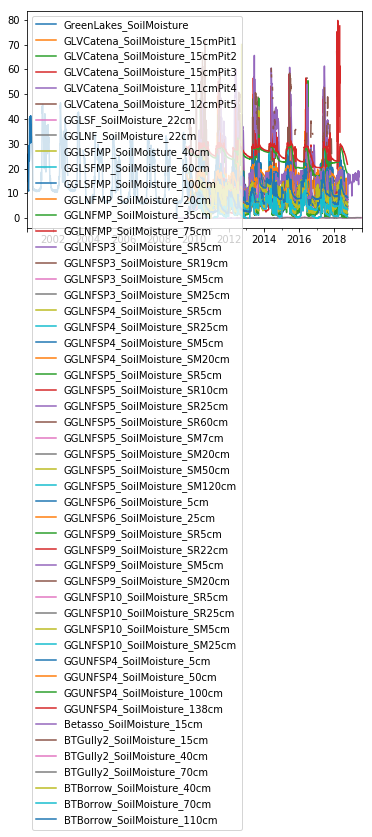

In [89]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j] # 
                       
SoilMoisture = copy.deepcopy(df)
SoilMoisture.plot()
SoilMoisture.head()

### 12. Soil Temperature

In [90]:
# Green Lakes
### D1 
prepG1 = pd.DataFrame(pd.to_numeric(dataGLV['GreenLakes_SoilTemperature']))
prepG1.head(2)

GreenLakes_SoilTemperature
DateTime                              
2000/07/05                        8.58
2000/07/06                        9.30

In [91]:
### Catena
prepG2 = copy.deepcopy(data_soil.iloc[:,[1,3,5,7,9]])
prepG2.head(2)

GLVCatena_SoilTemperature_15cmPit1  \
2009-09-29                               6.868   
2009-09-30                               5.233   

            GLVCatena_SoilTemperature_15cmPit2  \
2009-09-29                                5.75   
2009-09-30                                4.45   

            GLVCatena_SoilTemperature_15cmPit3  \
2009-09-29                               6.320   
2009-09-30                               4.757   

            GLVCatena_SoilTemperature_11cmPit4  \
2009-09-29                               7.686   
2009-09-30                               3.933   

            GLVCatena_SoilTemperature_12cmPit5  
2009-09-29                               5.022  
2009-09-30                               3.583

In [92]:
# Gordon Gulch
# GGLSF
prep1 = data1[[' SOIL TEMP(C)-22CM']] # actually rain gage
prep1.columns =['GGLSF_SoilTemperature_22cm']
prep1.index = pd.to_datetime(prep1.index)
prep1.head(2)

GGLSF_SoilTemperature_22cm
2012-06-20                       18.93
2012-06-21                       17.63

In [93]:
# GGLNF
prep2 = data2[[' SOIL TEMP(C)-22CM']] # actually rain gage
prep2.columns =['GGLNF_SoilTemperature_22cm']
prep2.index = pd.to_datetime(prep2.index)
prep2.head(2)

GGLNF_SoilTemperature_22cm
2012-06-08                       12.02
2012-06-09                       12.37

In [94]:
# Gordon Gulch: Lower - Electrical Conductivity, Soil Moisture, Soil Temperature - South-Facing Middle Pit 
# GGLSFMP
prep3 = copy.deepcopy(data3.iloc[:,[1,4,7]])
prep3.index = pd.to_datetime(prep3.index)
prep3.columns = ['GGLSFMP_SoilTemperature_40cm','GGLSFMP_SoilTemperature_60cm','GGLSFMP_SoilTemperature_100cm']
prep3.head(2)

GGLSFMP_SoilTemperature_40cm  GGLSFMP_SoilTemperature_60cm  \
2012-01-21                         1.224                           1.8   
2012-01-22                         1.393                           1.8   

            GGLSFMP_SoilTemperature_100cm  
2012-01-21                            2.7  
2012-01-22                            2.7

In [95]:
# Gordon Gulch: Lower - Electrical Conductivity, Soil Moisture, Soil Temperature - North-Facing Middle Pit 
# GGLNFMP
prep4 = copy.deepcopy(data4.iloc[:,[1,4,7]])
prep4.index = pd.to_datetime(prep4.index)
prep4.columns = ['GGLNFMP_SoilTemperature_20cm','GGLNFMP_SoilTemperature_35cm','GGLNFMP_SoilTemperature_75cm']
prep4.head(2)

GGLNFMP_SoilTemperature_20cm  GGLNFMP_SoilTemperature_35cm  \
2011-11-21                         0.348                         0.675   
2011-11-22                         0.070                         0.500   

            GGLNFMP_SoilTemperature_75cm  
2011-11-21                         1.285  
2011-11-22                         1.257

In [96]:
# GGLNFSP3
prep = copy.deepcopy(datasp3.iloc[:,[0,2,4,6]])
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP3_SoilTemperature_SR5cm','GGLNFSP3_SoilTemperature_SR19cm',
                 'GGLNFSP3_SoilTemperature_SM5cm','GGLNFSP3_SoilTemperature_SM25cm']
prep5 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep5.head(2)


GGLNFSP3_SoilTemperature_SR5cm  GGLNFSP3_SoilTemperature_SR19cm  \
2010-06-01                        8.703986                         6.835889   
2010-06-02                        8.475125                         7.038687   

            GGLNFSP3_SoilTemperature_SM5cm  GGLNFSP3_SoilTemperature_SM25cm  
2010-06-01                       10.047375                         7.523257  
2010-06-02                        9.533611                         7.711111

In [97]:
# GGLNFSP4
prep = copy.deepcopy(datasp4.iloc[:,[0,2,4,6]])
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP4_SoilTemperature_SR5cm','GGLNFSP4_SoilTemperature_SR25cm',
                 'GGLNFSP4_SoilTemperature_SM5cm','GGLNFSP4_SoilTemperature_SM20cm']
prep6 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep6.head(2)

GGLNFSP4_SoilTemperature_SR5cm  GGLNFSP4_SoilTemperature_SR25cm  \
2009-09-12                             NaN                              NaN   
2009-09-13                             NaN                              NaN   

            GGLNFSP4_SoilTemperature_SM5cm  GGLNFSP4_SoilTemperature_SM20cm  
2009-09-12                        8.500661                         9.612279  
2009-09-13                        9.152335                         9.170592

In [98]:
# GGLNFSP5
prep = copy.deepcopy(datasp5.iloc[:,[0,2,4,6,8,10,12,14]])
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP5_SoilTemperature_SR5cm','GGLNFSP5_SoilTemperature_SR10cm',
                'GGLNFSP5_SoilTemperature_SR25cm','GGLNFSP5_SoilTemperature_SR60cm',
                'GGLNFSP5_SoilTemperature_SM7cm','GGLNFSP5_SoilTemperature_SM20cm',
                'GGLNFSP5_SoilTemperature_SM50cm','GGLNFSP5_SoilTemperature_SM120cm']
prep7 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep7.head(2)

GGLNFSP5_SoilTemperature_SR5cm  GGLNFSP5_SoilTemperature_SR10cm  \
2009-09-07                             NaN                              NaN   
2009-09-08                             NaN                              NaN   

            GGLNFSP5_SoilTemperature_SR25cm  GGLNFSP5_SoilTemperature_SR60cm  \
2009-09-07                              NaN                              NaN   
2009-09-08                              NaN                              NaN   

            GGLNFSP5_SoilTemperature_SM7cm  GGLNFSP5_SoilTemperature_SM20cm  \
2009-09-07                       11.676508                        10.685814   
2009-09-08                       10.737443                        10.428272   

            GGLNFSP5_SoilTemperature_SM50cm  GGLNFSP5_SoilTemperature_SM120cm  
2009-09-07                         9.398085                          8.310863  
2009-09-08                         9.417912                          8.305274

In [99]:
# GGLNFSP6
prep = copy.deepcopy(datasp6.iloc[:,[0,2]])
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP6_SoilTemperature_5cm','GGLNFSP6_SoilTemperature_25cm']
prep8 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep8.head(2)

GGLNFSP6_SoilTemperature_5cm  GGLNFSP6_SoilTemperature_25cm
2009-09-02                      0.018810                       0.075987
2009-09-03                      0.018847                       0.075233

In [100]:
# GGLNFSP9
prep = copy.deepcopy(datasp9.iloc[:,[0,2,4,6]])
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP9_SoilTemperature_SR5cm','GGLNFSP9_SoilTemperature_SR22cm',
                 'GGLNFSP9_SoilTemperature_SM5cm','GGLNFSP9_SoilTemperature_SM20cm']
prep9 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep9.head(2)

GGLNFSP9_SoilTemperature_SR5cm  GGLNFSP9_SoilTemperature_SR22cm  \
2010-04-06                             NaN                              NaN   
2010-04-07                             NaN                              NaN   

            GGLNFSP9_SoilTemperature_SM5cm  GGLNFSP9_SoilTemperature_SM20cm  
2010-04-06                        3.640013                         5.935785  
2010-04-07                        2.069576                         4.910868

In [101]:
# GGLNFSP10
prep = copy.deepcopy(datasp10.iloc[:,[0,2,4,6]])
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGLNFSP10_SoilTemperature_SR5cm','GGLNFSP10_SoilTemperature_SR25cm',
                 'GGLNFSP10_SoilTemperature_SM5cm','GGLNFSP10_SoilTemperature_SM25cm']
prep10 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep10.head(2)

GGLNFSP10_SoilTemperature_SR5cm  GGLNFSP10_SoilTemperature_SR25cm  \
2010-02-09                         0.653701                          1.390675   
2010-02-10                         0.615232                          1.422976   

            GGLNFSP10_SoilTemperature_SM5cm  GGLNFSP10_SoilTemperature_SM25cm  
2010-02-09                              NaN                               NaN  
2010-02-10                              NaN                               NaN

In [102]:
# GGLNFSP11
prep = copy.deepcopy(dataggu.iloc[:,[1,3,5,7]])
prep.index = pd.to_datetime(prep.index)
prep.columns = ['GGUNFSP4_SoilTemperature_5cm','GGUNFSP4_SoilTemperature_50cm',
               'GGUNFSP4_SoilTemperature_100cm','GGUNFSP4_SoilTemperature_138cm']
prep11 = copy.deepcopy(prep.groupby(prep.index.date).mean())
prep11.head(2)

GGUNFSP4_SoilTemperature_5cm  GGUNFSP4_SoilTemperature_50cm  \
2009-08-04                     14.109487                      12.791395   
2009-08-05                     12.912512                      12.340743   

            GGUNFSP4_SoilTemperature_100cm  GGUNFSP4_SoilTemperature_138cm  
2009-08-04                             NaN                        7.967768  
2009-08-05                             NaN                        7.921034

In [103]:
### Betasso
prep12 = copy.deepcopy(dataBetasso[['Betasso_SoilTemperature_15cm']])
prep12.head(2)

Betasso_SoilTemperature_15cm
2009-02-04                         5.217
2009-02-05                         3.944

In [104]:
df_lst=[prepG1,prepG2,prep1,prep2,prep3,prep4,prep5,prep6,prep7,prep8,prep9,prep10,prep11,prep12]
for df in df_lst:
    df.index=pd.to_datetime(df.index)
    df = threC(df,'SoilTemperature')
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep = threC(prep,'SoilTemperature')

The final table is:


GreenLakes_SoilTemperature GLVCatena_SoilTemperature_15cmPit1  \
2000-07-05                       8.58                                NaN   
2000-07-06                        9.3                                NaN   

           GLVCatena_SoilTemperature_15cmPit2  \
2000-07-05                                NaN   
2000-07-06                                NaN   

           GLVCatena_SoilTemperature_15cmPit3  \
2000-07-05                                NaN   
2000-07-06                                NaN   

           GLVCatena_SoilTemperature_11cmPit4  \
2000-07-05                                NaN   
2000-07-06                                NaN   

           GLVCatena_SoilTemperature_12cmPit5 GGLSF_SoilTemperature_22cm  \
2000-07-05                                NaN                        NaN   
2000-07-06                                NaN                        NaN   

           GGLNF_SoilTemperature_22cm GGLSFMP_SoilTemperature_40cm  \
2000-07-05                        NaN                          NaN   
2000-07-06                        NaN                          NaN   

           GGLSFMP_SoilTemperature_60cm  ... GGLNFSP9_SoilTemperature_SM20cm  \
2000-07-05                          NaN  ...                             NaN   
2000-07-06                          NaN  ...                             NaN   

           GGLNFSP10_SoilTemperature_SR5cm GGLNFSP10_SoilTemperature_SR25cm  \
2000-07-05                             NaN                              NaN   
2000-07-06                             NaN                              NaN   

           GGLNFSP10_SoilTemperature_SM5cm GGLNFSP10_SoilTemperature_SM25cm  \
2000-07-05                             NaN                              NaN   
2000-07-06                             NaN                              NaN   

           GGUNFSP4_SoilTemperature_5cm GGUNFSP4_SoilTemperature_50cm  \
2000-07-05                          NaN                           NaN   
2000-07-06                          NaN                           NaN   

           GGUNFSP4_SoilTemperature_100cm GGUNFSP4_SoilTemperature_138cm  \
2000-07-05                            NaN                            NaN   
2000-07-06                            NaN                            NaN   

           Betasso_SoilTemperature_15cm  
2000-07-05                          NaN  
2000-07-06                          NaN  

[2 rows x 45 columns]

GreenLakes_SoilTemperature GLVCatena_SoilTemperature_15cmPit1  \
2019-07-21                        NaN                                NaN   
2019-07-22                        NaN                                NaN   

           GLVCatena_SoilTemperature_15cmPit2  \
2019-07-21                                NaN   
2019-07-22                                NaN   

           GLVCatena_SoilTemperature_15cmPit3  \
2019-07-21                                NaN   
2019-07-22                                NaN   

           GLVCatena_SoilTemperature_11cmPit4  \
2019-07-21                                NaN   
2019-07-22                                NaN   

           GLVCatena_SoilTemperature_12cmPit5 GGLSF_SoilTemperature_22cm  \
2019-07-21                                NaN                       15.8   
2019-07-22                                NaN                       16.6   

           GGLNF_SoilTemperature_22cm GGLSFMP_SoilTemperature_40cm  \
2019-07-21                        NaN                          NaN   
2019-07-22                        NaN                          NaN   

           GGLSFMP_SoilTemperature_60cm  ... GGLNFSP9_SoilTemperature_SM20cm  \
2019-07-21                          NaN  ...                             NaN   
2019-07-22                          NaN  ...                             NaN   

           GGLNFSP10_SoilTemperature_SR5cm GGLNFSP10_SoilTemperature_SR25cm  \
2019-07-21                             NaN                              NaN   
2019-07-22                             NaN                              NaN   

           GGLNFSP10_SoilTemperature_SM5cm GGLNFSP10_SoilTemperature_SM25cm  \
2019-07-21                             NaN                              NaN   
2019-07-22                             NaN                              NaN   

           GGUNFSP4_SoilTemperature_5cm GGUNFSP4_SoilTemperature_50cm  \
2019-07-21                          NaN                           NaN   
2019-07-22                          NaN                           NaN   

           GGUNFSP4_SoilTemperature_100cm GGUNFSP4_SoilTemperature_138cm  \
2019-07-21                            NaN                            NaN   
2019-07-22                            NaN                            NaN   

           Betasso_SoilTemperature_15cm  
2019-07-21                          NaN  
2019-07-22                          NaN  

[2 rows x 45 columns]

GreenLakes_SoilTemperature
GLVCatena_SoilTemperature_15cmPit1
GLVCatena_SoilTemperature_15cmPit2
GLVCatena_SoilTemperature_15cmPit3
GLVCatena_SoilTemperature_11cmPit4
GLVCatena_SoilTemperature_12cmPit5
GGLSF_SoilTemperature_22cm
GGLNF_SoilTemperature_22cm
GGLSFMP_SoilTemperature_40cm
GGLSFMP_SoilTemperature_60cm
GGLSFMP_SoilTemperature_100cm
GGLNFMP_SoilTemperature_20cm
GGLNFMP_SoilTemperature_35cm
GGLNFMP_SoilTemperature_75cm
GGLNFSP3_SoilTemperature_SR5cm
GGLNFSP3_SoilTemperature_SR19cm
GGLNFSP3_SoilTemperature_SM5cm
GGLNFSP3_SoilTemperature_SM25cm
GGLNFSP4_SoilTemperature_SR5cm
GGLNFSP4_SoilTemperature_SR25cm
GGLNFSP4_SoilTemperature_SM5cm
GGLNFSP4_SoilTemperature_SM20cm
GGLNFSP5_SoilTemperature_SR5cm
GGLNFSP5_SoilTemperature_SR10cm
GGLNFSP5_SoilTemperature_SR25cm
GGLNFSP5_SoilTemperature_SR60cm
GGLNFSP5_SoilTemperature_SM7cm
GGLNFSP5_SoilTemperature_SM20cm
GGLNFSP5_SoilTemperature_SM50cm
GGLNFSP5_SoilTemperature_SM120cm
GGLNFSP6_SoilTemperature_5cm
GGLNFSP6_SoilTemperature_25cm
GGL

GreenLakes_SoilTemperature  GLVCatena_SoilTemperature_15cmPit1  \
2000-07-05                        8.58                                 NaN   
2000-07-06                        9.30                                 NaN   
2000-07-07                        9.55                                 NaN   
2000-07-08                        9.40                                 NaN   
2000-07-09                        8.71                                 NaN   

            GLVCatena_SoilTemperature_15cmPit2  \
2000-07-05                                 NaN   
2000-07-06                                 NaN   
2000-07-07                                 NaN   
2000-07-08                                 NaN   
2000-07-09                                 NaN   

            GLVCatena_SoilTemperature_15cmPit3  \
2000-07-05                                 NaN   
2000-07-06                                 NaN   
2000-07-07                                 NaN   
2000-07-08                                 NaN   
2000-07-09                                 NaN   

            GLVCatena_SoilTemperature_11cmPit4  \
2000-07-05                                 NaN   
2000-07-06                                 NaN   
2000-07-07                                 NaN   
2000-07-08                                 NaN   
2000-07-09                                 NaN   

            GLVCatena_SoilTemperature_12cmPit5  GGLSF_SoilTemperature_22cm  \
2000-07-05                                 NaN                         NaN   
2000-07-06                                 NaN                         NaN   
2000-07-07                                 NaN                         NaN   
2000-07-08                                 NaN                         NaN   
2000-07-09                                 NaN                         NaN   

            GGLNF_SoilTemperature_22cm  GGLSFMP_SoilTemperature_40cm  \
2000-07-05                         NaN                           NaN   
2000-07-06                         NaN                           NaN   
2000-07-07                         NaN                           NaN   
2000-07-08                         NaN                           NaN   
2000-07-09                         NaN                           NaN   

            GGLSFMP_SoilTemperature_60cm  ...  \
2000-07-05                           NaN  ...   
2000-07-06                           NaN  ...   
2000-07-07                           NaN  ...   
2000-07-08                           NaN  ...   
2000-07-09                           NaN  ...   

            GGLNFSP9_SoilTemperature_SM20cm  GGLNFSP10_SoilTemperature_SR5cm  \
2000-07-05                              NaN                              NaN   
2000-07-06                              NaN                              NaN   
2000-07-07                              NaN                              NaN   
2000-07-08                              NaN                              NaN   
2000-07-09                              NaN                              NaN   

            GGLNFSP10_SoilTemperature_SR25cm  GGLNFSP10_SoilTemperature_SM5cm  \
2000-07-05                               NaN                              NaN   
2000-07-06                               NaN                              NaN   
2000-07-07                               NaN                              NaN   
2000-07-08                               NaN                              NaN   
2000-07-09                               NaN                              NaN   

            GGLNFSP10_SoilTemperature_SM25cm  GGUNFSP4_SoilTemperature_5cm  \
2000-07-05                               NaN                           NaN   
2000-07-06                               NaN                           NaN   
2000-07-07                               NaN                           NaN   
2000-07-08                               NaN                           NaN   
2000-07-09                               NaN                           NaN   

      

<Figure size 720x288 with 0 Axes>

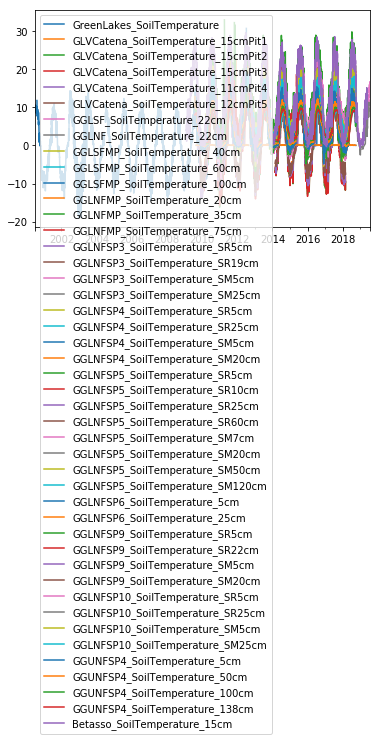

In [105]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j] # 
                       
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()
SoilTemperature.head()

In [106]:
### 13. Isotope

### Result

In [107]:
result = pd.concat([Discharge,Precipitation,AirTemperature,SolarRadiation,RelativeHumidity,
                    WindSpeed,WindDirection,
                    SnowDepth,SoilMoisture,SoilTemperature],
                    axis=1,
                    join='outer')
result.index.rename('DateTime', inplace = True)
result.head(5)

Fourmile_Discharge  Boulder_Discharge  Longmont_Discharge  \
DateTime                                                                
1989-01-01           15.857408          2208.7104           2435.2448   
1989-01-02           15.857408          2491.8784           2661.7792   
1989-01-03           15.857408          2803.3632           3114.8480   
1989-01-04           15.857408          2180.3936           2661.7792   
1989-01-05           15.857408          1840.5920           2321.9776   

            GGLSF_Precipitation  GGLNF_Precipitation  Betasso_Precipitation  \
DateTime                                                                      
1989-01-01                  NaN                  NaN                    NaN   
1989-01-02                  NaN                  NaN                    NaN   
1989-01-03                  NaN                  NaN                    NaN   
1989-01-04                  NaN                  NaN                    NaN   
1989-01-05                  NaN                  NaN                    NaN   

            GreenLakes_AirTemperature  GGLSF_AirTemperature  \
DateTime                                                      
1989-01-01                        NaN                   NaN   
1989-01-02                        NaN                   NaN   
1989-01-03                        NaN                   NaN   
1989-01-04                        NaN                   NaN   
1989-01-05                        NaN                   NaN   

            GGLNF_AirTemperature  Betasso_AirTemperature_2m  ...  \
DateTime                                                     ...   
1989-01-01                   NaN                        NaN  ...   
1989-01-02                   NaN                        NaN  ...   
1989-01-03                   NaN                        NaN  ...   
1989-01-04                   NaN                        NaN  ...   
1989-01-05                   NaN                        NaN  ...   

            GGLNFSP9_SoilTemperature_SM20cm  GGLNFSP10_SoilTemperature_SR5cm  \
DateTime                                                                       
1989-01-01                              NaN                              NaN   
1989-01-02                              NaN                              NaN   
1989-01-03                              NaN                              NaN   
1989-01-04                              NaN                              NaN   
1989-01-05                              NaN                              NaN   

            GGLNFSP10_SoilTemperature_SR25cm  GGLNFSP10_SoilTemperature_SM5cm  \
DateTime                                                                        
1989-01-01                               NaN                              NaN   
1989-01-02                               NaN                              NaN   
1989-01-03                               NaN                              NaN   
1989-01-04                               NaN                              NaN   
1989-01-05                               NaN                              NaN   

            GGLNFSP10_SoilTemperature_SM25cm  GGUNFSP4_SoilTemperature_5cm  \
DateTime                                                                     
1989-01-01                               NaN                           NaN   
1989-01-02                               NaN                           NaN   
1989-01-03                               NaN                           NaN   
1989-01-04                               NaN                           NaN   
1989-01-05                               NaN                           NaN   

            GGUNFSP4_SoilTemperature_50cm  GGUNFSP4_SoilTemperature_100cm  \
DateTime                                                                    
1989-01-01                            NaN                             NaN   
1989-01-02                            NaN                             NaN   
1989-01-03                            NaN  

In [108]:
result.to_csv('1_Boulder_Download_Aggregation_Daily.csv', sep=',')